# Machine Learning Model for Telco Customer Churn

## Background and Problem
Customer churn becomes one of the most important metrics to understand in a business. It tells us about how retain our customers towards our product/services. The higher the churn rate is, the more likely our customer to not use our product/service anymore, and this is concerning, since impacting to our revenue in a business. 

Therefore, in this dataset, we're going to learn what's the factor of customer churn from Telco Customer Churn dataset. 

The dataset is represented as follows

- Each row represents a customer, each column contains customer’s attributes described on the column Metadata.
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

Here, we're going to utilize machine learning classification model to predict whether the customer churn or not using Decision Tree, Random Forest, and XGBoost, and perform analytical metrics towards those model to see which one is better.

## Outlines

What we're going to cover in this notebook

1. Data Profiling and Cleaning
2. Categorical Encoding
3. Multicollinearity 
4. Data Preparation
5. Building Machine Learning Model with Imbalanced Data : Decision Tree, Random Forest, XGBoost Classifier
6. Balacing Data using SMOTE Technique
7. Building Machine Learning Model with Balanced Data
8. Decision Tree Visualizations : Educational Purposes
9. Hyperparameters Tuning
10. Conclusion


# Data Profiling and Cleaning

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import time
import re

pd.set_option('display.max_columns', 200)

plt.style.use('bmh')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Libraries to calculate multicollinearity or VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

In [2]:
# Import Telco Customer Churn dataset
df = pd.read_csv('./dataset/Telco-Customer-Churn.csv')

# Dealing with missing values/ null value
df = df.drop(df[df['TotalCharges'] == ' '].index)
df['TotalCharges'] = df['TotalCharges'].astype('float')

In [3]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [4]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7032.000000  7032.000000     7032.000000   7032.000000
mean        0.162400    32.421786       64.798208   2283.300441
std         0.368844    24.545260       30.085974   2266.771362
min         0.000000     1.000000       18.250000     18.800000
25%         0.000000     9.000000       35.587500    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.862500   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 
 17  

Here, we get general info of the dataset. It contains 7032 rows and have 21 features with **Churn** as our target variable. An interesting part is 17 features are an object type data or categorical value, and only 4 features are numeric.

Also, we don't have any missing value here.

Let's categorize those columns into categorical, ordinal, and numeric columns as represented below. 

- categorical : the value stands for binary value, something like **yes** and **no**, or **female** and **male**
- ordinal : variables with an ondered lists
- numeric : variables with discrete or continous numerical value

In [6]:
category_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines','OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','PaperlessBilling']

ordinal_columns = ['InternetService', 'Contract', 'PaymentMethod']

numerical_columns = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [7]:
def categorical_plots(df, category, type):

    num_cols = 3
    length = len(category)
    num_rows = length // 3 + 1 if length % 3 != 0 else length // 3 

    if type == 'categorical':
        size_x, size_y = (15, 9)
    elif type == 'ordinal' :
        size_x, size_y = (15,4)
        
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(size_x,size_y))

    colors = ['#EC7063', '#A569BD','#EC407A', '#2196F3', '#00ACC1', '#FB8C00']
              
    for index, axes in enumerate(axs.flatten()[:length]):
        df[category[index]].value_counts(normalize=False).plot(kind='bar',
                                                               ax = axes, 
                                                               title = category[index].capitalize(),
                                                               color = colors[index]).set_xlabel("")
        axes.set_ylim(0,10000)

        if type == 'categorical':
            axes.tick_params(axis='x', rotation=0)
        elif type == 'ordinal':
            axes.tick_params(axis='x', rotation=45)
    
        position = df[category[index]].value_counts(normalize=True)
        get_position = df[category[index]].value_counts(normalize=False).to_list()
        data_point = position.apply(lambda x : x*100).astype('str').apply(lambda x : x[:5] +" %").tolist()

        for i in range(len(get_position)):
            axes.text(i, get_position[i] + 200, data_point[i], 
                      ha='center', color = 'black', fontsize=10)
    
    plt.subplots_adjust(wspace=0.2, 
                        hspace=0.3)
    
    #plt.savefig(path + f'uninvariate-{type}-value.png')

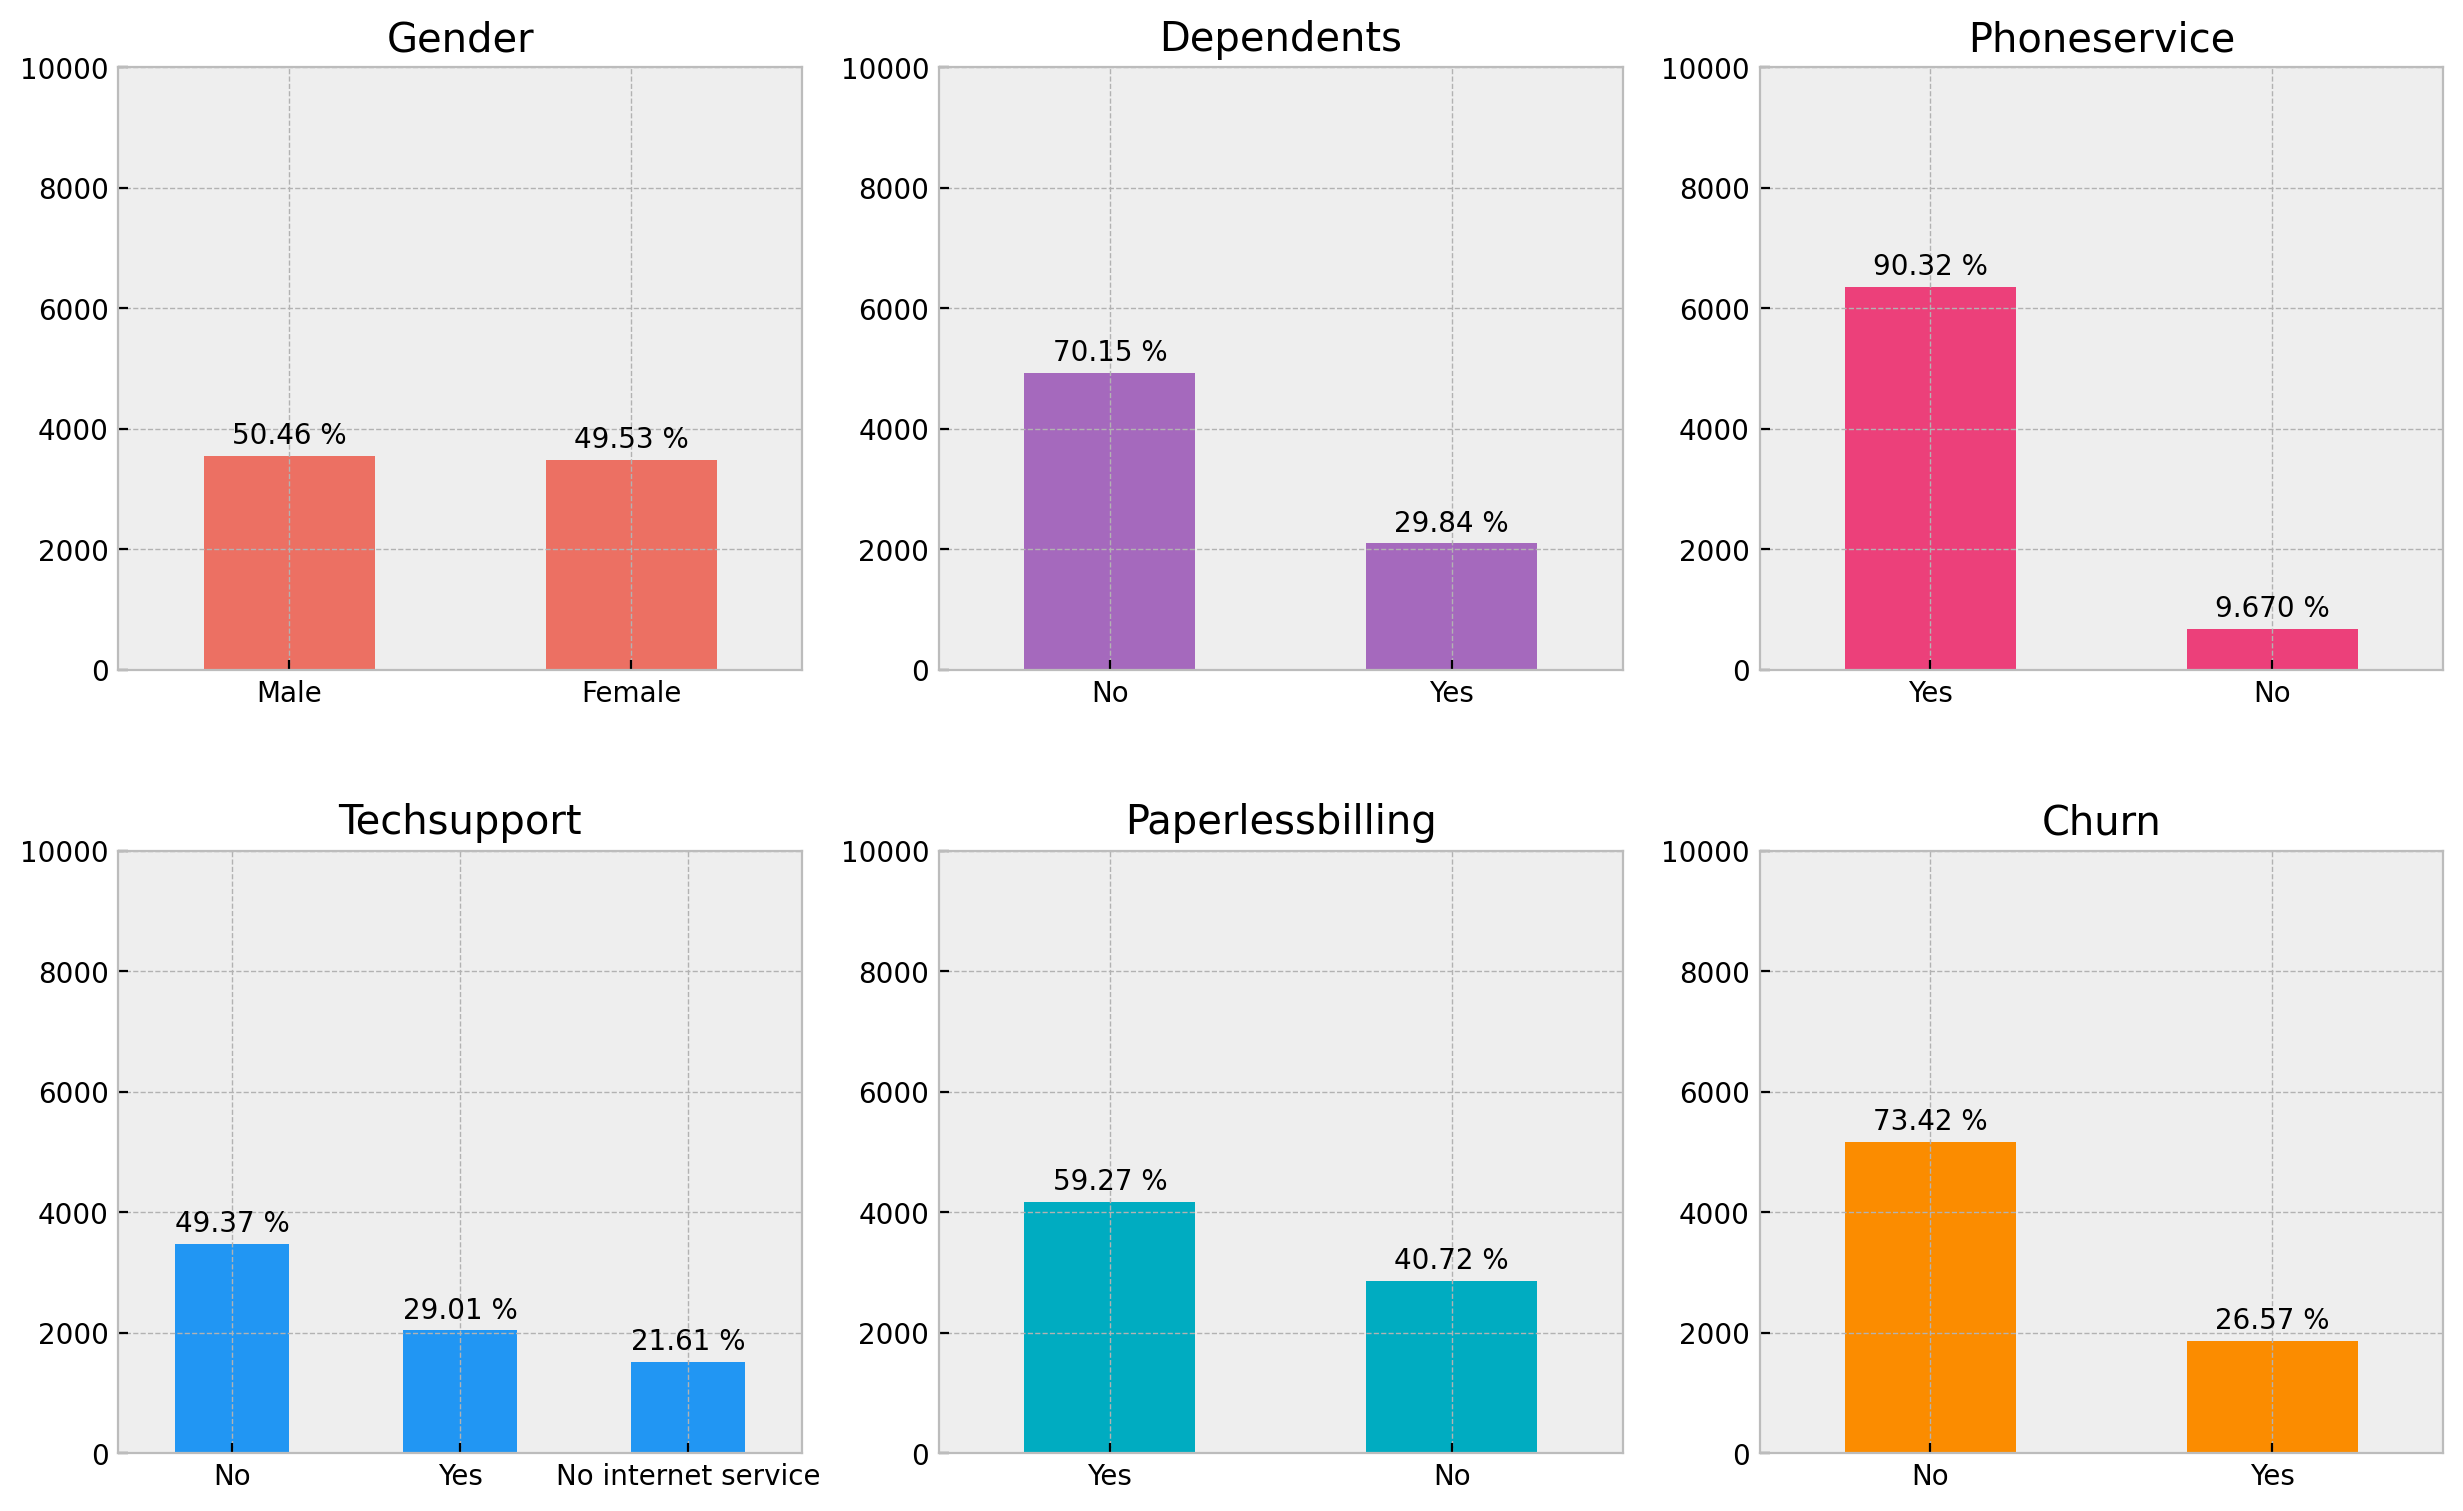

In [8]:
category = ['gender', 'Dependents', 'PhoneService',
            'TechSupport', 'PaperlessBilling', 'Churn']
categorical_plots(df, category, 'categorical')

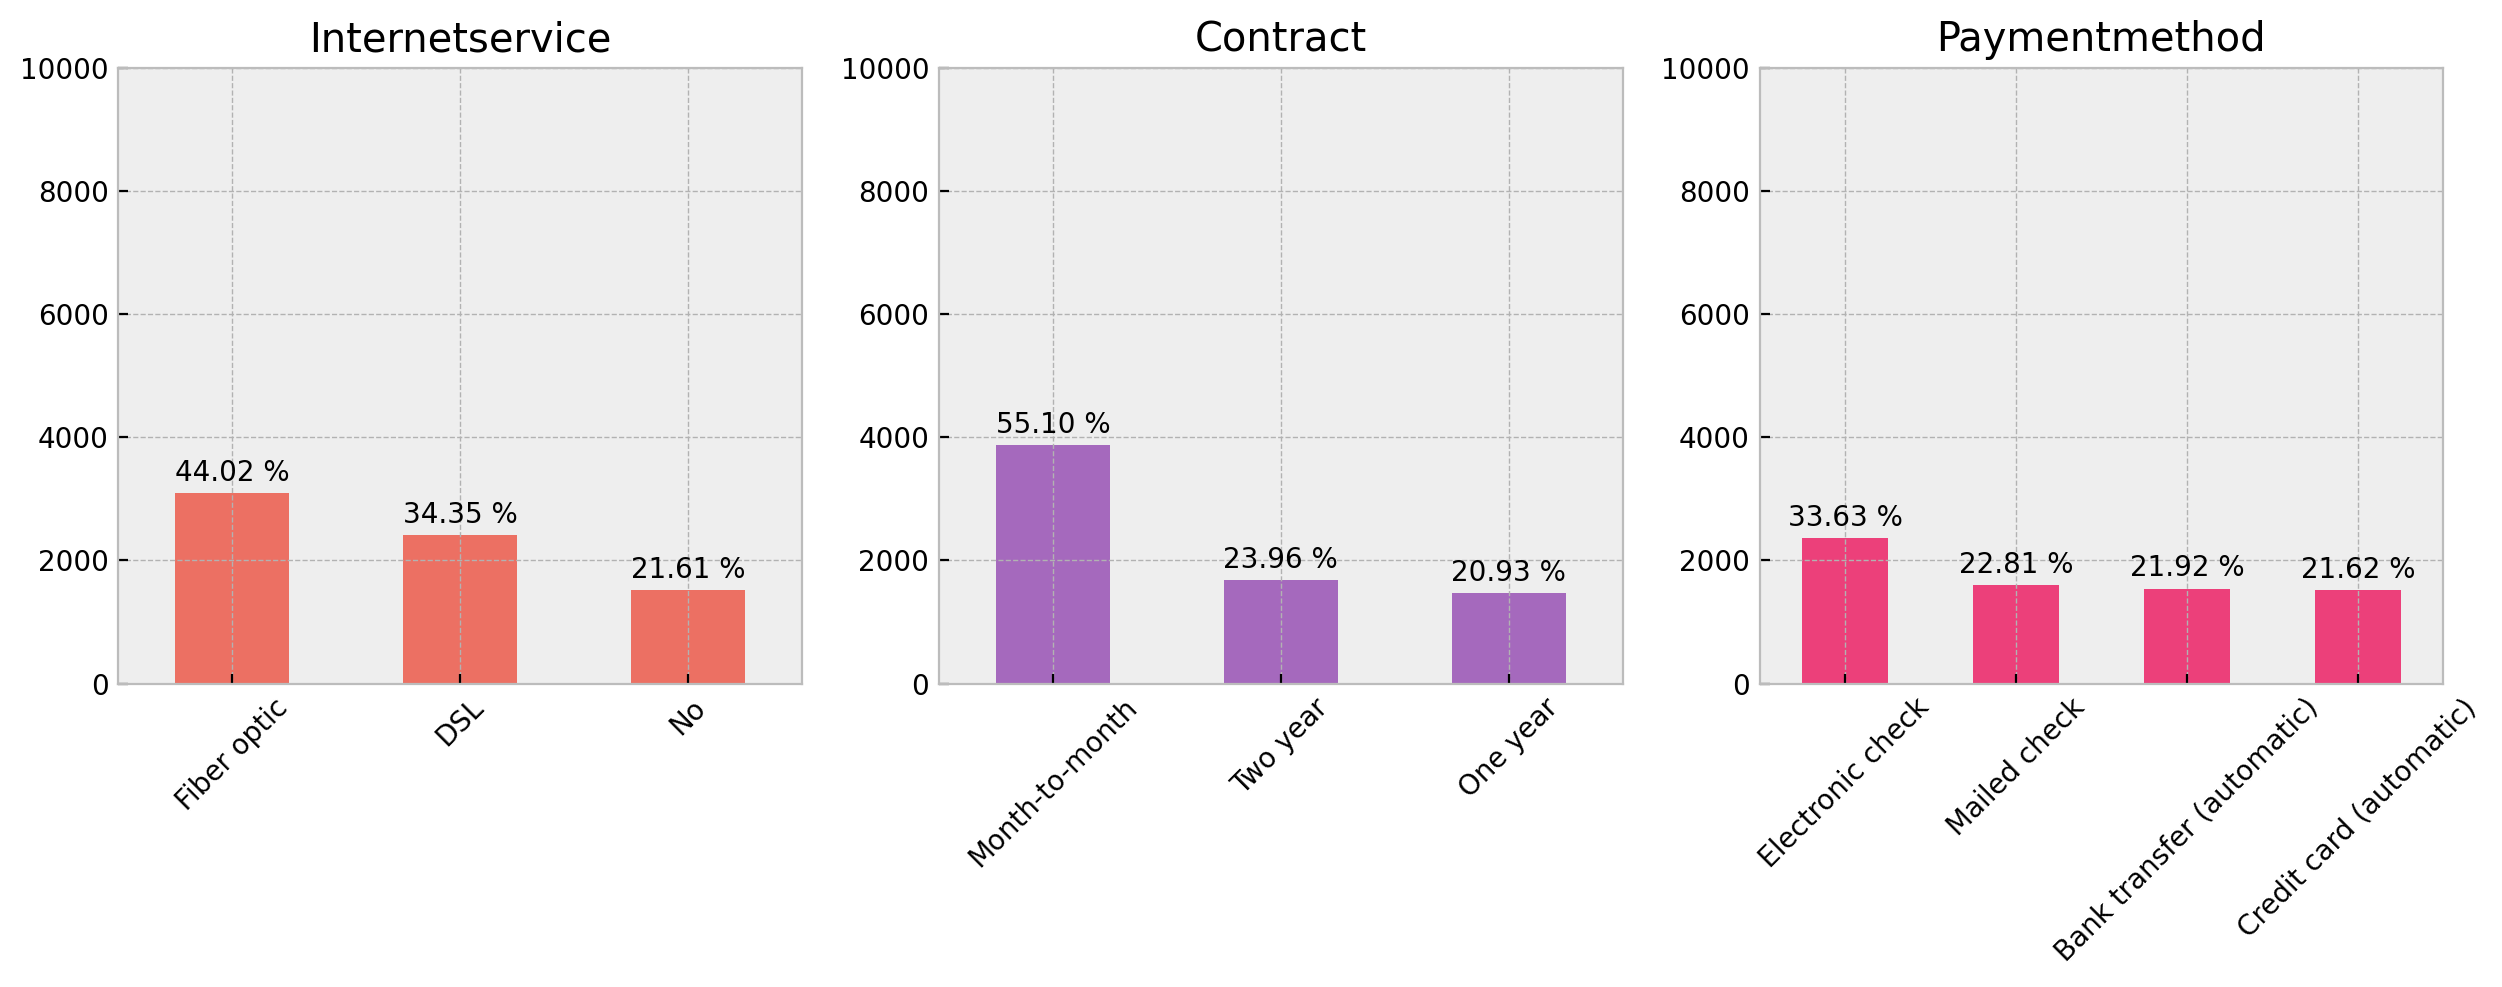

In [9]:
categorical_plots(df, ordinal_columns, 'ordinal')

In [10]:
def numeric_plot(df, numerical, type):
    
    numeric = numerical_columns[1:]
    columns = ['Tenure', 'Monthly Charges', 'Total Charges']
    
    fig_num, axes_num = plt.subplots(1,3, figsize= (18,5))

    colors = ['#EC407A', '#A569BD','#00ACC1']
    
    for index, axes in enumerate(axes_num.ravel()):
        if type == 'hist':
            plot = sns.histplot(df[numeric[index]], 
                                kde=True, ax=axes, color = colors[index])
        elif type == 'box':
            plot =  sns.boxplot(df[numeric[index]], 
                                ax=axes, color = colors[index])
        plot.set(xlabel = '', ylabel='Frequency', title = columns[index])
        
        
    fig_num.tight_layout()
    #plt.savefig(path + f'numeric-{type}-value.png')


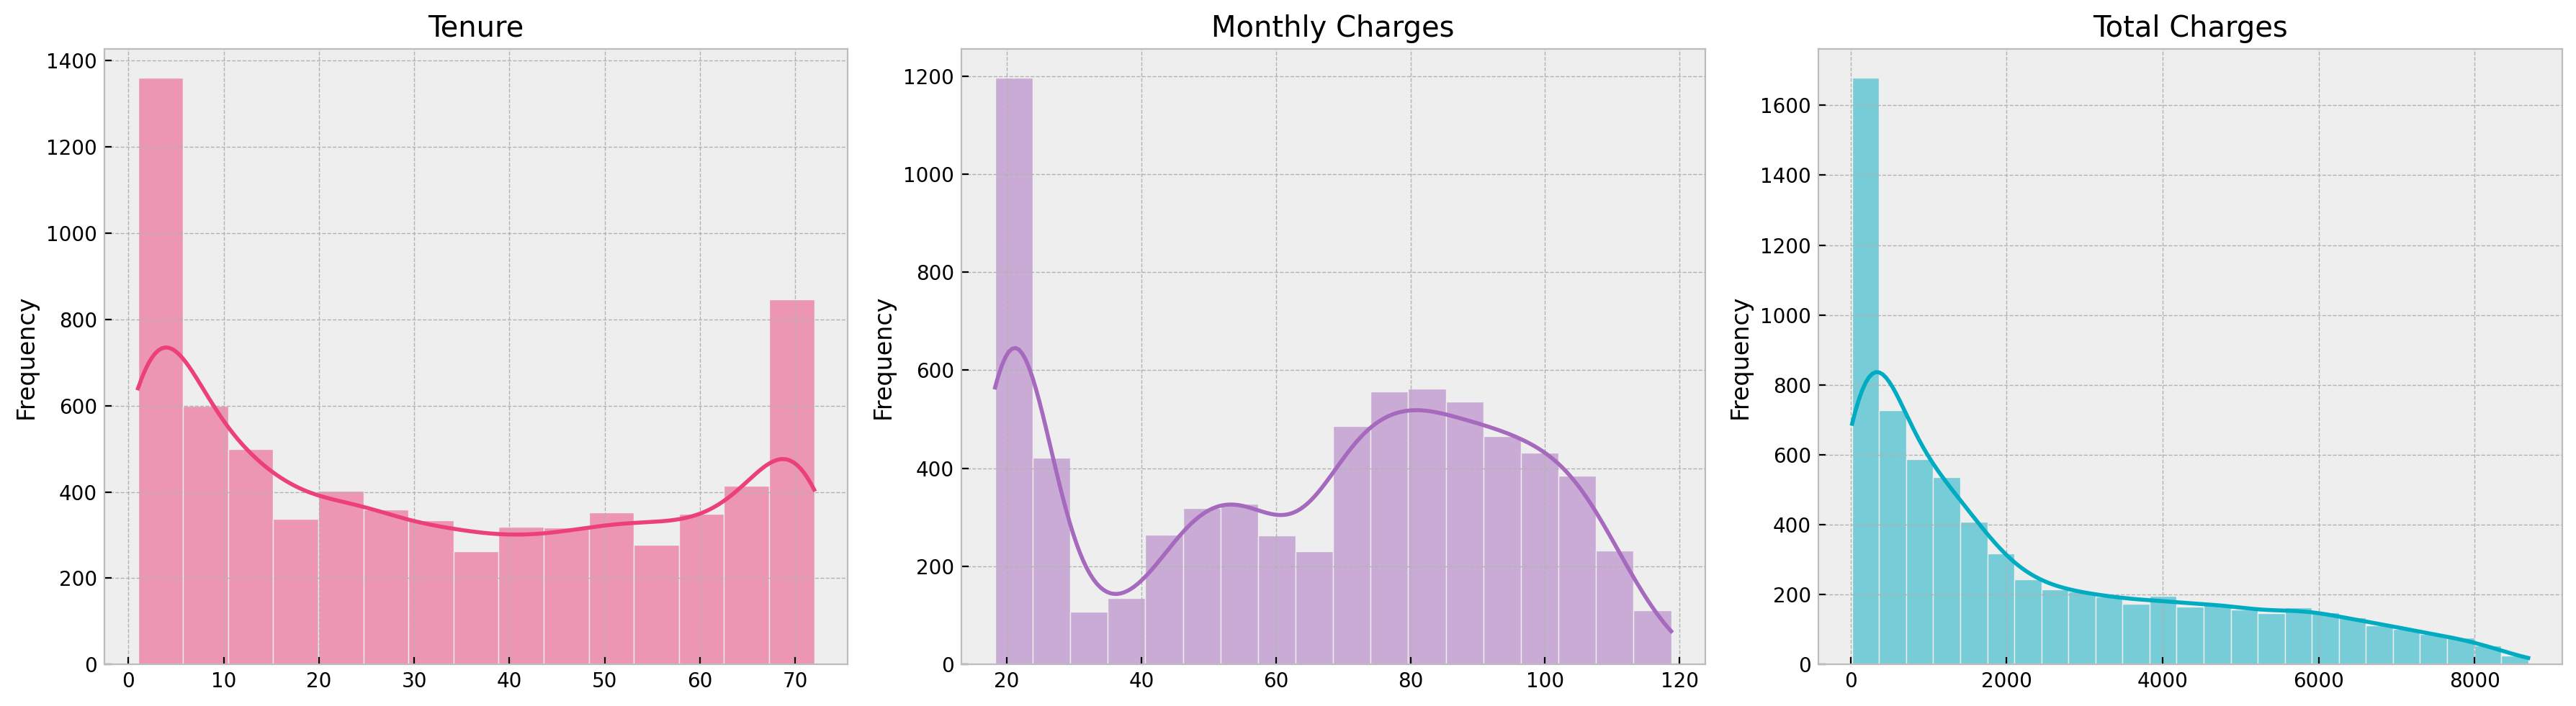

In [11]:
numeric_plot(df, numerical_columns, 'hist')

In [12]:
def bivariate_bar_plot(df, ordinal_columns, target_variabel, type):

    if type == 'bar':
    
        fig, axs = plt.subplots(1, 3, figsize=(12,5))
    
        colors = ["Set2", "flare"]
        
        for index, axes in enumerate(axs.flatten()):
            
            plot = sns.countplot(x = ordinal_columns[index], hue = target_variabel, data=df, 
                                 ax = axes, palette = colors[index])
        
            plot.set(xlabel='', ylabel = 'Frequency', title=ordinal_columns[index])
                        
            for index, p in enumerate(axes.patches):    
                height = p.get_height()
                x = p.get_x() + (p.get_width()/2)
                if x != 0.0:
                    axes.text(x, y = height + 30, s = '{:.0f}'.format(height), ha = 'center')
                    
    elif type == 'barstacked':
        
        fig, axs = plt.subplots(1,3, figsize = (18,5))
    
        colors = [['tomato','lightseagreen'], ['#A569BD','#00ACC1'], ['#00ACC1', '#FB8C00']]
        
        for index, axes in enumerate(axs.flatten()):
            df_stack = df.groupby([target_variabel, ordinal_columns[index]]).size().reset_index()
            df_stack = df_stack.pivot(columns= target_variabel, index= ordinal_columns[index], values=0)
            df_reverse = df_stack[df_stack.columns[::-1]]
            
            df_reverse.plot(kind='bar', stacked=True, ax = axes, 
                            title = ordinal_columns[index], color = colors[index],
                            ylabel = 'Frequency').set_xlabel("")
        
            axes.tick_params(axis='x', rotation=0)
            
            for c in axes.containers:
                label = [int(l.get_height()) for l in c]
                axes.bar_label(c, labels = label, label_type = 'edge') 

    #plt.savefig(path + f'bivariate-{type}-value.png')


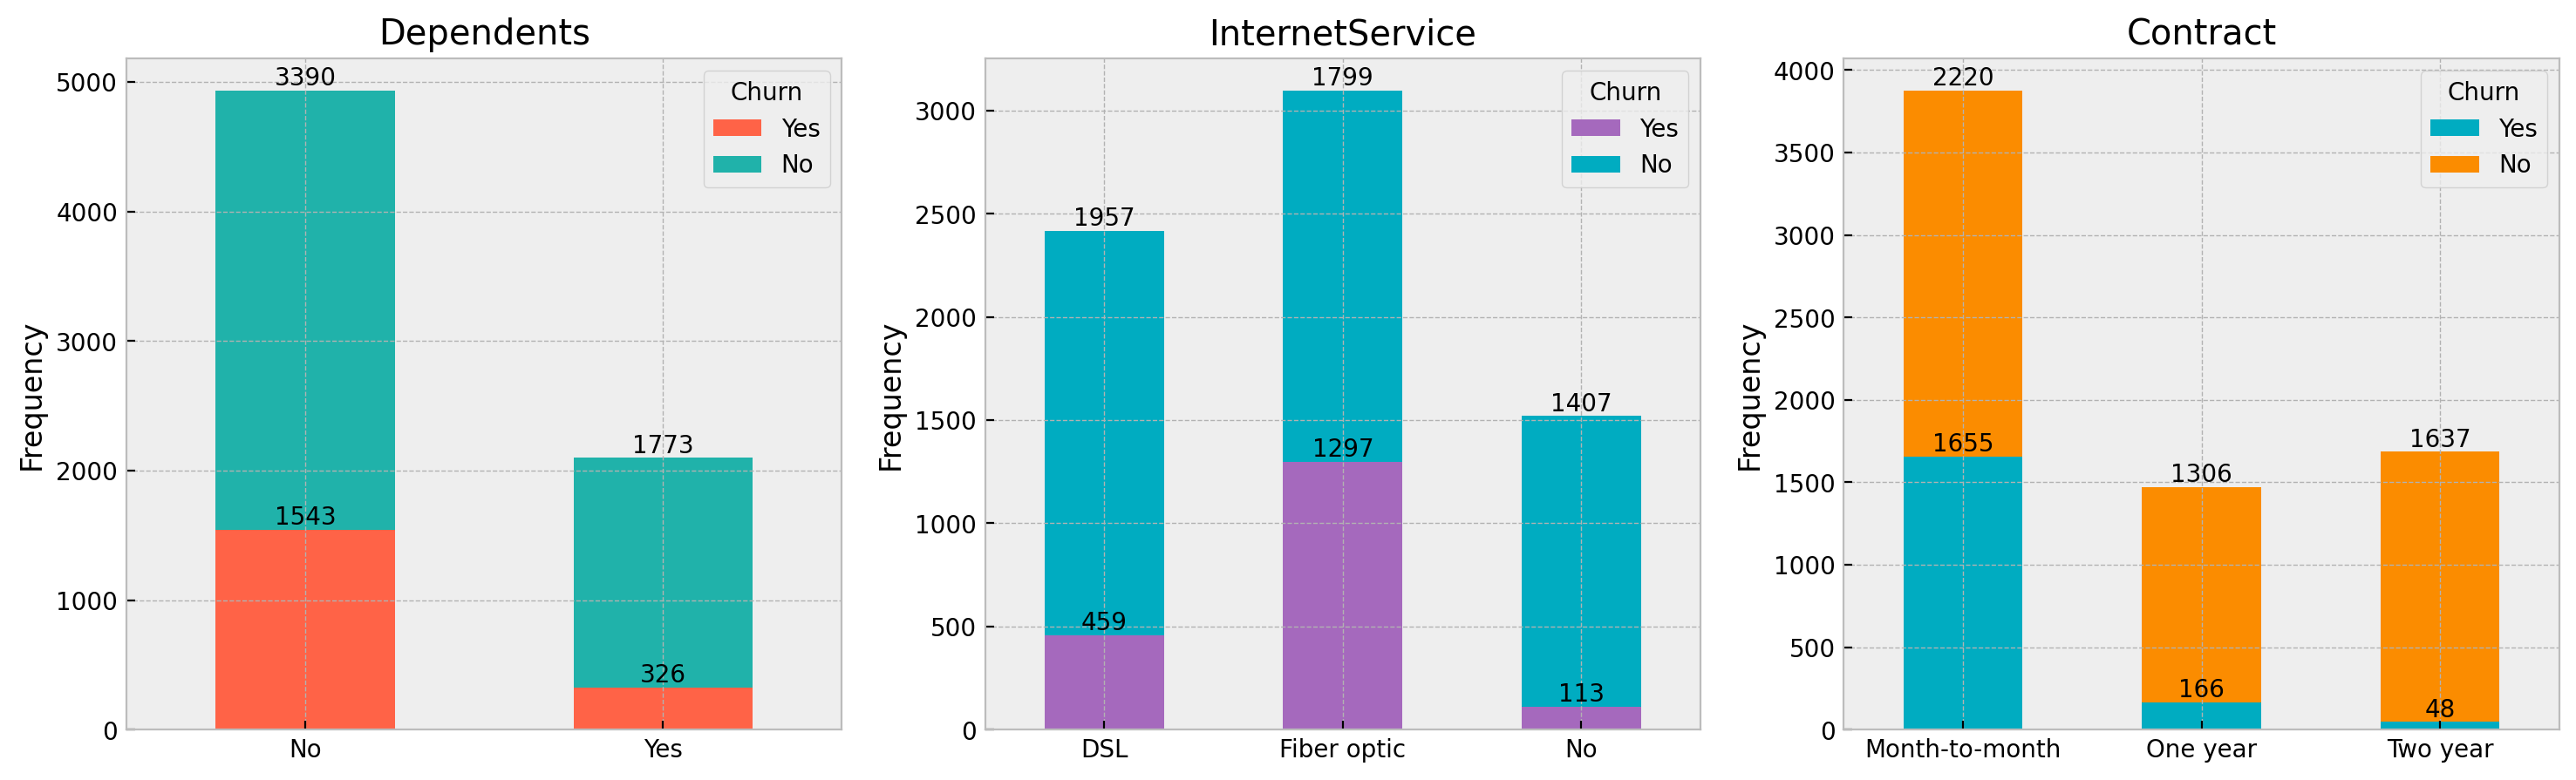

In [13]:
columns = ['Dependents', 'InternetService', 'Contract']
bivariate_bar_plot(df, columns, 'Churn', 'barstacked')

In [14]:
def multivariate_plots(df, numeric, category, target_variable):
    
    bin = np.linspace(df[numeric].min(), df[numeric].max(), 50)
    graph = sns.FacetGrid(df, col=category, hue = target_variable, palette="Set2", 
                          col_wrap=3, height = 7, aspect=1.1)
    graph.map(plt.hist, numeric, bins=bin, ec="k")
    
    for ax in graph.axes.ravel():
        ax.legend(title= target_variable)
        
    graph.set(ylabel = 'Frequency', xlabel= numeric)

    #plt.savefig(path + 'multivariate-value.png')
    
    plt.show()

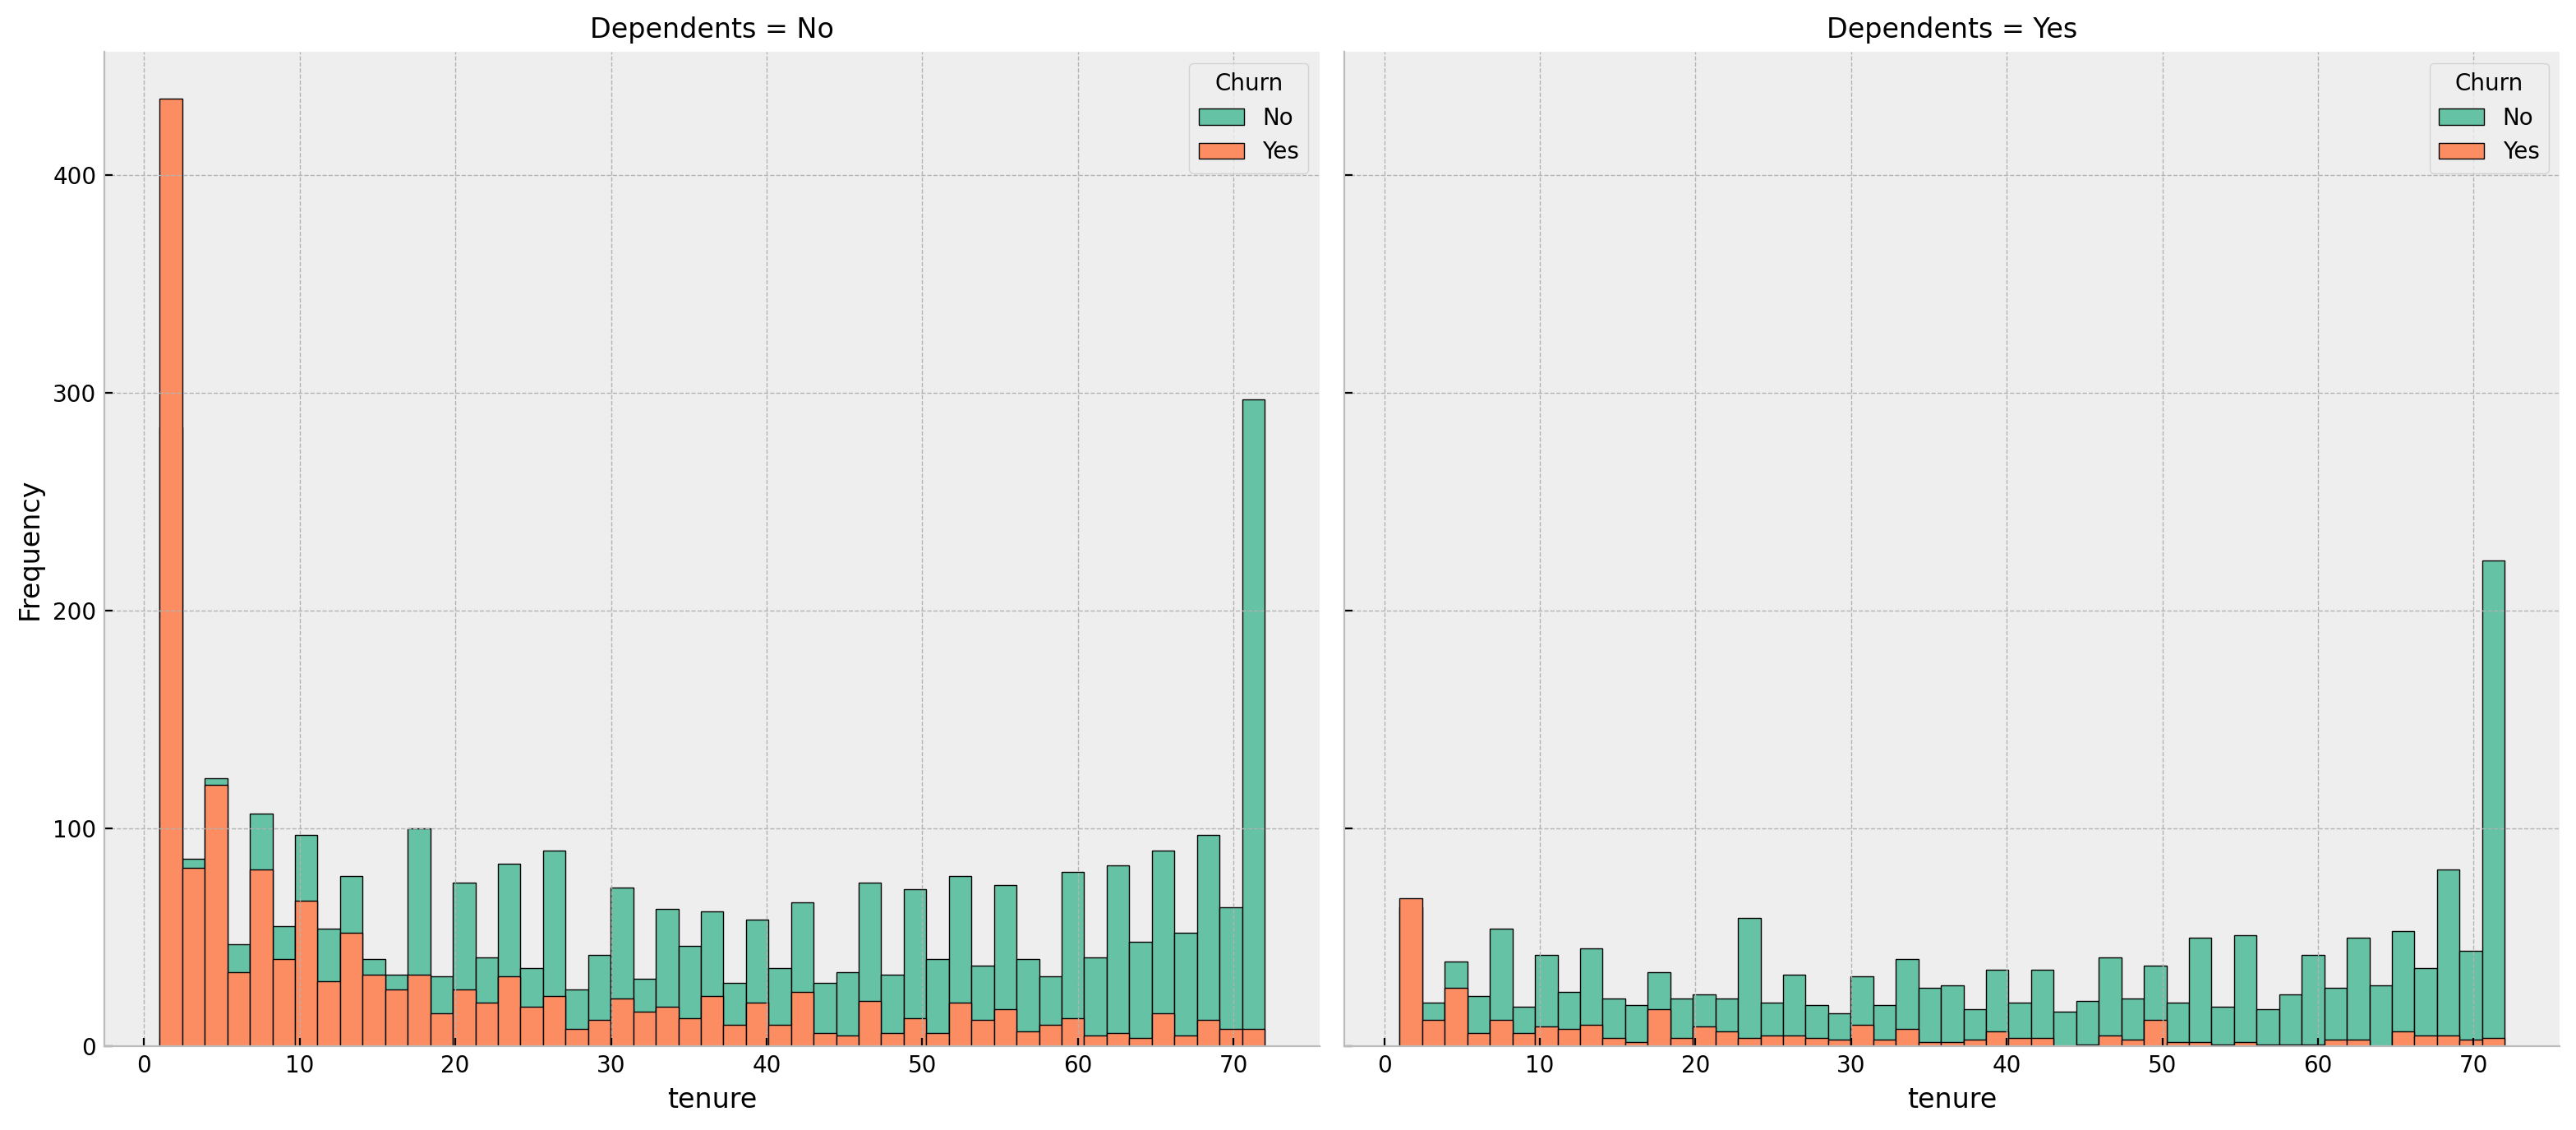

In [15]:
multivariate_plots(df, 'tenure', 'Dependents', 'Churn')

In [16]:
for col in df.columns:
    if df[col].dtypes == object:
        print('{} : {}'.format(col, df[col].unique()))

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


In [17]:
# Encode the categorical variable into numeric
def label_encoding(df, ordinal_columns):

    categoricals = df.drop(columns = ordinal_columns, axis=1).columns
    
    for col in categoricals:
        df[col] = df[col].replace({'Male' : 1.0, 'Female' : 0.0,
                                   'Yes' : 1.0, 'No' : 0.0,
                                   'No phone service' : 0.0,
                                   'No internet service' : 0.0})
        
    return df.drop(columns = 'customerID', axis=1)

# Encode ordinal columns, and drop first encoding-columns to avoid multicollinearity
def onehotencoding(df, columns):
    
    onehot = pd.DataFrame()
    for col in columns:
        encoding = pd.get_dummies(df[col], prefix=col, dtype='float')
        encoding = encoding.drop(encoding.columns[-1], axis=1)
        onehot = pd.concat([onehot, encoding], axis=1)
    
    return onehot

# Calculate multicollinearity
def calculate_vif(feature):
    X = add_constant(feature)
    vif_df = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])], 
                          index = X.columns).reset_index()
    vif_df.columns = ['feature', 'vif_score']
    vif_df = vif_df.loc[vif_df.feature != 'const']
    return vif_df

# Final cleaning to get feature and target data
def feature_cleaning(df, ordinal_columns):
    df_encode = label_encoding(df, ordinal_columns)

    # Drop the ordinal columns from dataframe first
    df_encode = df_encode.drop(columns=ordinal_columns)
    feature = df_encode.drop(columns='Churn')
    target = df_encode['Churn']
    target = target.astype('int')

    # Drop MonthlyCharges and TotalCharges since their vif score are high/ high correlated
    feature = feature.drop(columns=['MonthlyCharges', 'TotalCharges'], axis=1)

    # Encode ordinal columns in the dataframe
    onehot = onehotencoding(df, ordinal_columns)
    feature = pd.concat([feature, onehot], axis=1)
    return feature, target

In [18]:
feature, target = feature_cleaning(df, ordinal_columns)

# Check the vif score
calculate_vif(feature)

feature  vif_score
1                                    gender   1.001769
2                             SeniorCitizen   1.153168
3                                   Partner   1.462369
4                                Dependents   1.380811
5                                    tenure   2.827609
6                              PhoneService   1.354768
7                             MultipleLines   1.423682
8                            OnlineSecurity   1.415235
9                              OnlineBackup   1.380823
10                         DeviceProtection   1.480118
11                              TechSupport   1.481353
12                              StreamingTV   1.625973
13                          StreamingMovies   1.634755
14                         PaperlessBilling   1.208329
15                      InternetService_DSL   3.584572
16              InternetService_Fiber optic   4.103973
17                  Contract_Month-to-month   3.575390
18                        Contract_One year   1.698819
19  PaymentMethod_Bank transfer (automatic)   1.787030
20    PaymentMethod_Credit card (automatic)   1.764089
21           PaymentMethod_Electronic check   2.142102

<Axes: >

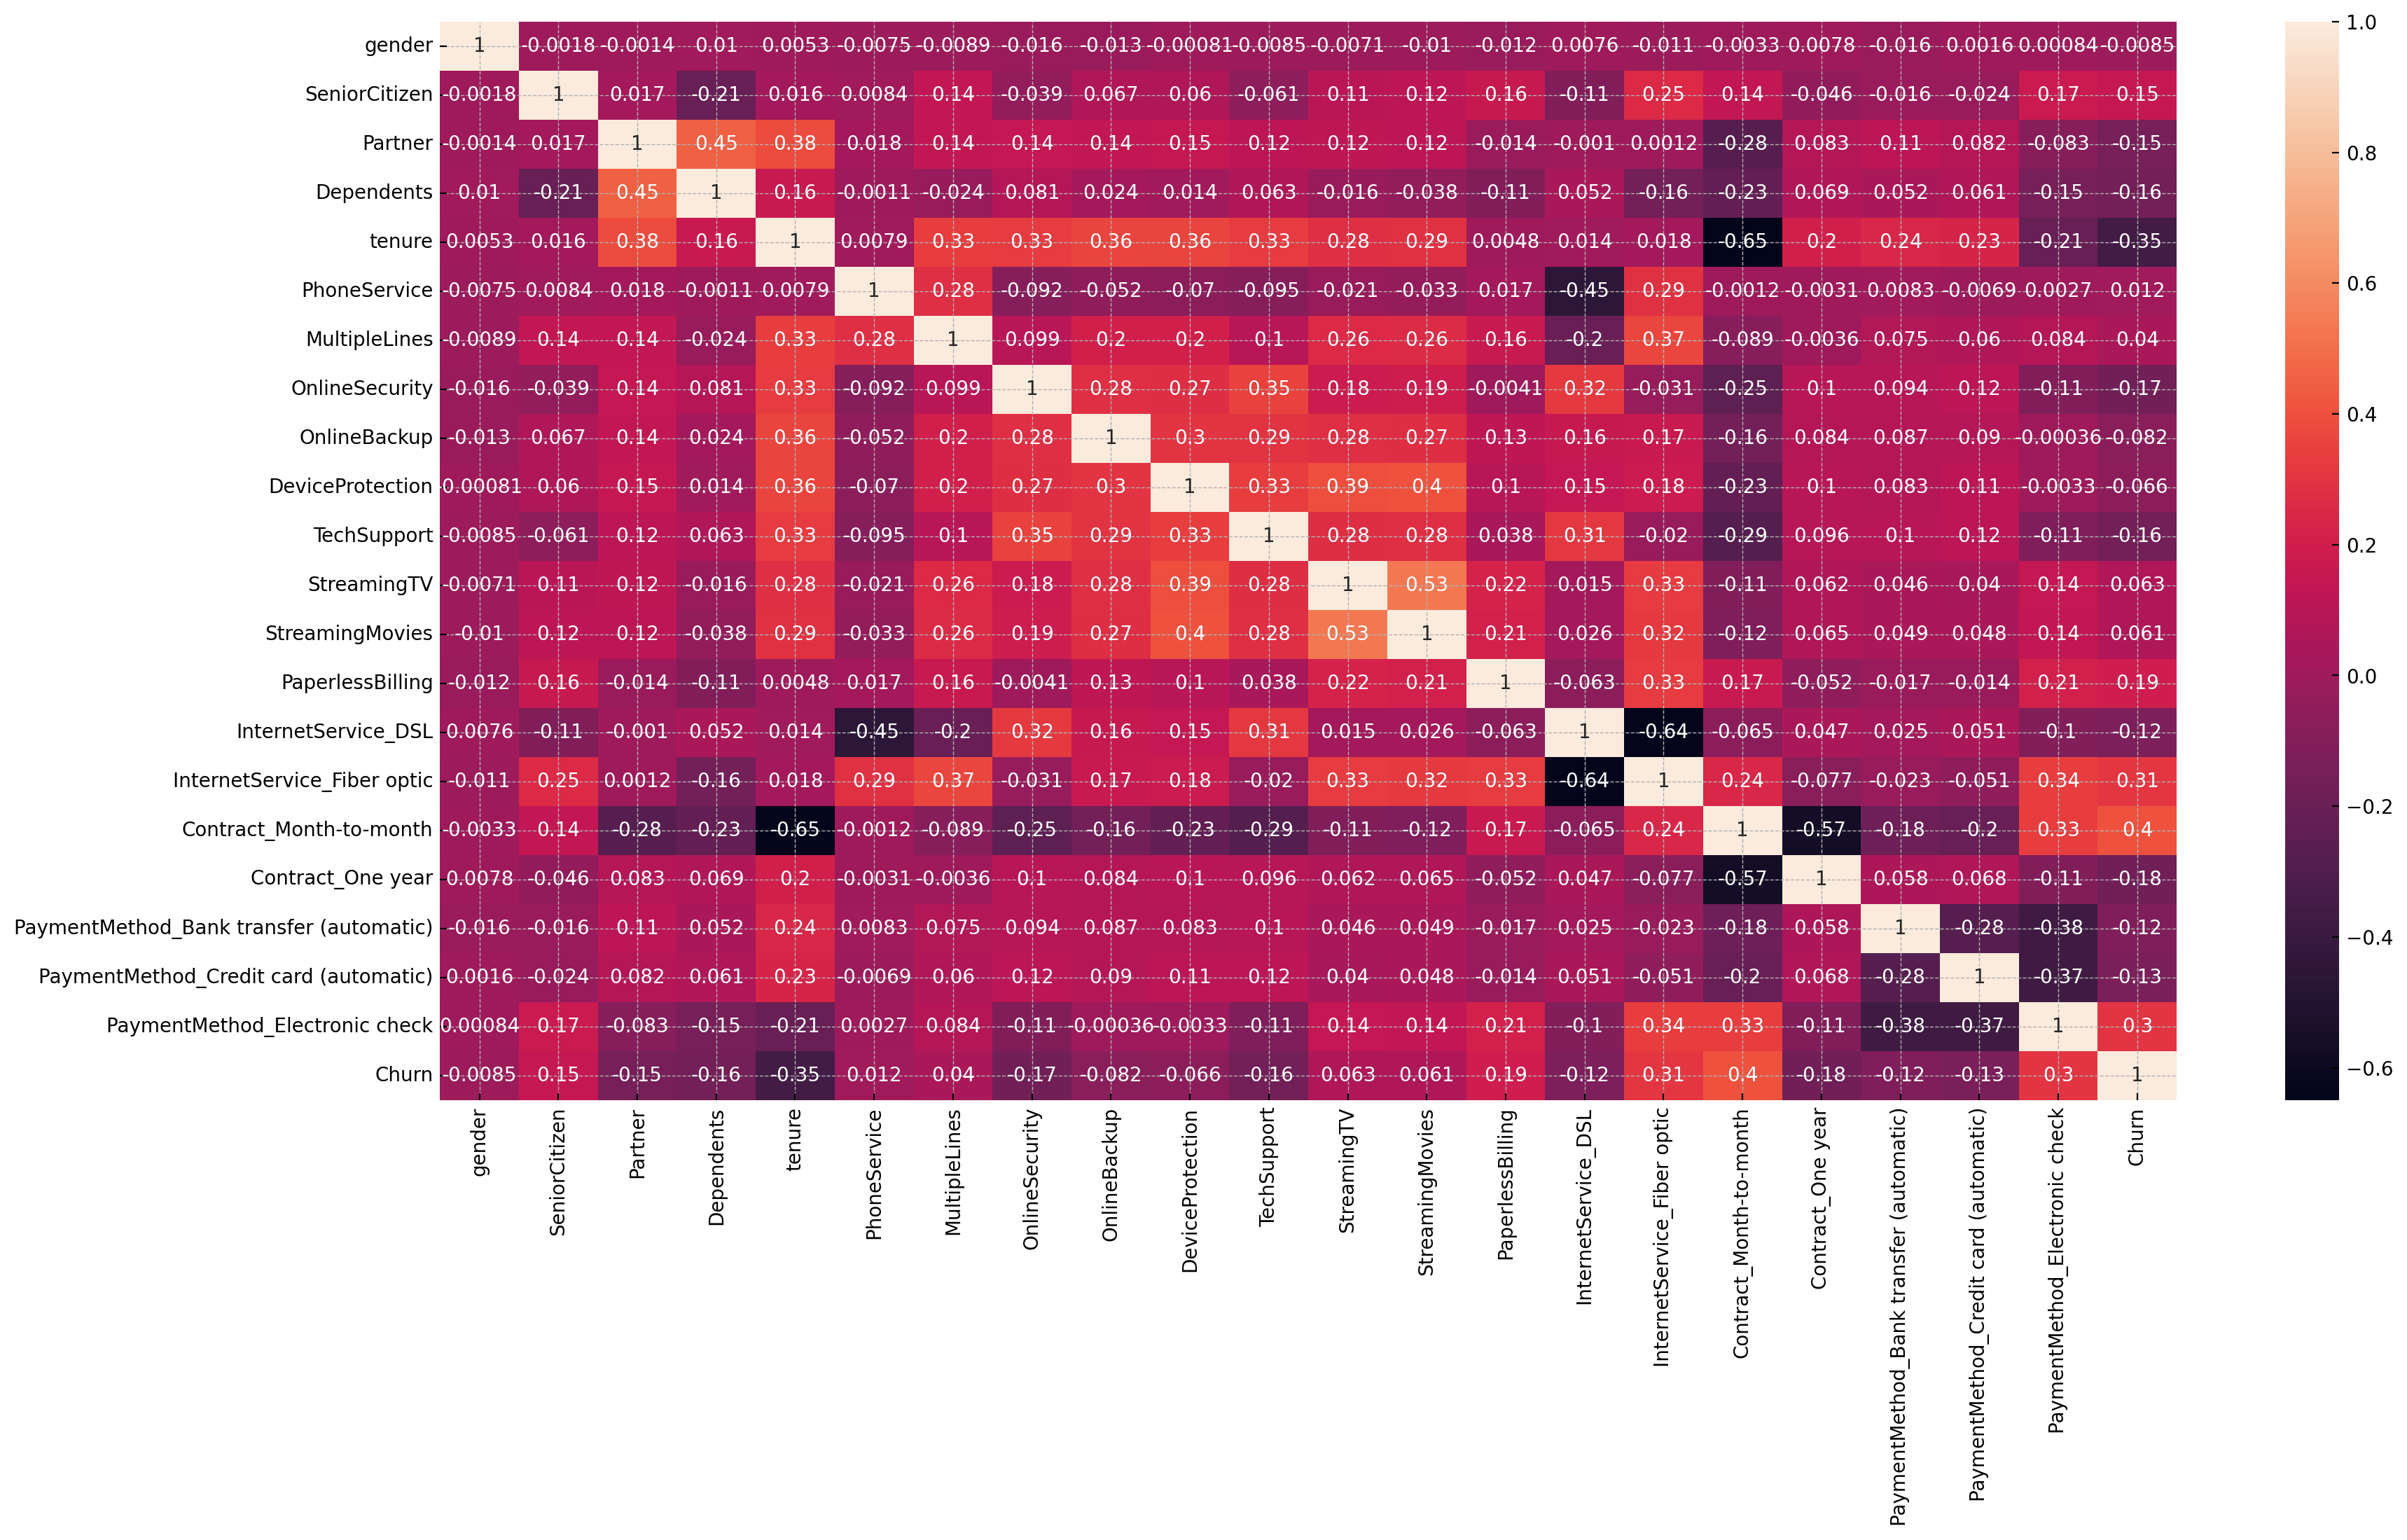

In [19]:
correlation = pd.concat([feature, target], axis=1)

plt.figure(figsize=(20,10))
sns.heatmap(correlation.corr(), annot=True)

## Machine Learning Model

In [20]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score
from sklearn.metrics import classification_report

X_pretrain, X_val, y_pretrain, y_val = train_test_split(feature, 
                                                        target, 
                                                        test_size=0.2,
                                                        random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_pretrain, 
                                                    y_pretrain, 
                                                    test_size=0.2,
                                                    random_state=42)

# Original feature and target shape of our dataset
print('Shape of original feature data : {}'.format(feature.shape))
print('Shape of original target data : {}'.format(target.shape))
print()

# Shape of X_train and y_train data 
print('Shape of X_train data : {}'.format(X_train.shape))
print('Shape of y_train data : {}'.format(y_train.shape))
print()

# Shape of X_test and y_test data 
print('Shape of X_test data : {}'.format(X_test.shape))
print('Shape of y_test data : {}'.format(y_test.shape))
print()

# Shape of X_val and y_val data 
print('Shape of X_val data : {}'.format(X_val.shape))
print('Shape of y_val data : {}'.format(y_val.shape))
print()

Shape of original feature data : (7032, 21)
Shape of original target data : (7032,)

Shape of X_train data : (4500, 21)
Shape of y_train data : (4500,)

Shape of X_test data : (1125, 21)
Shape of y_test data : (1125,)

Shape of X_val data : (1407, 21)
Shape of y_val data : (1407,)



In [21]:
# Model fitting and calculation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Decision tree classifier
tree = DecisionTreeClassifier()
tree.fit(X_train.to_numpy(), y_train.to_numpy())

# Random forest classifier
forest = RandomForestClassifier()
forest.fit(X_train.to_numpy(), y_train.to_numpy())

# XGBosst classifier
xgb = XGBClassifier()
xgb.fit(X_train.to_numpy(), y_train.to_numpy())

models = [tree, forest, xgb]

In [22]:
def confusion_matrix_viz(model, X_train, X_test, X_val, y_train, y_test, y_val):

    name = type(model).__name__
    name = re.findall('[A-Z][^A-Z]*', name)
    model_name = ''.join(name[:-1])

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    categories = ['No Churn', 'Churn']

    data_label = ['Training', 'Test', 'Validation']
    
    X = [X_train, X_test, X_val]
    y = [y_train, y_test, y_val]
    
    fig, axs = plt.subplots(1, 3, figsize=(20,5))

    for i, axes in enumerate(axs.flatten()):
        y_pred = model.predict(X[i])
        cm = confusion_matrix(y[i], y_pred)
    
        group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
        group_percentage = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
        
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentage)]
        labels = np.asarray(labels).reshape(2,2)
    
        plot = sns.heatmap(cm, annot=labels, fmt='', 
                           ax = axes, cmap='Blues', cbar = True,
                           xticklabels = categories, yticklabels=categories)
        plot.set(title = model_name + ' --- ' + data_label[i], xlabel='Predicted Value', ylabel='True Value')

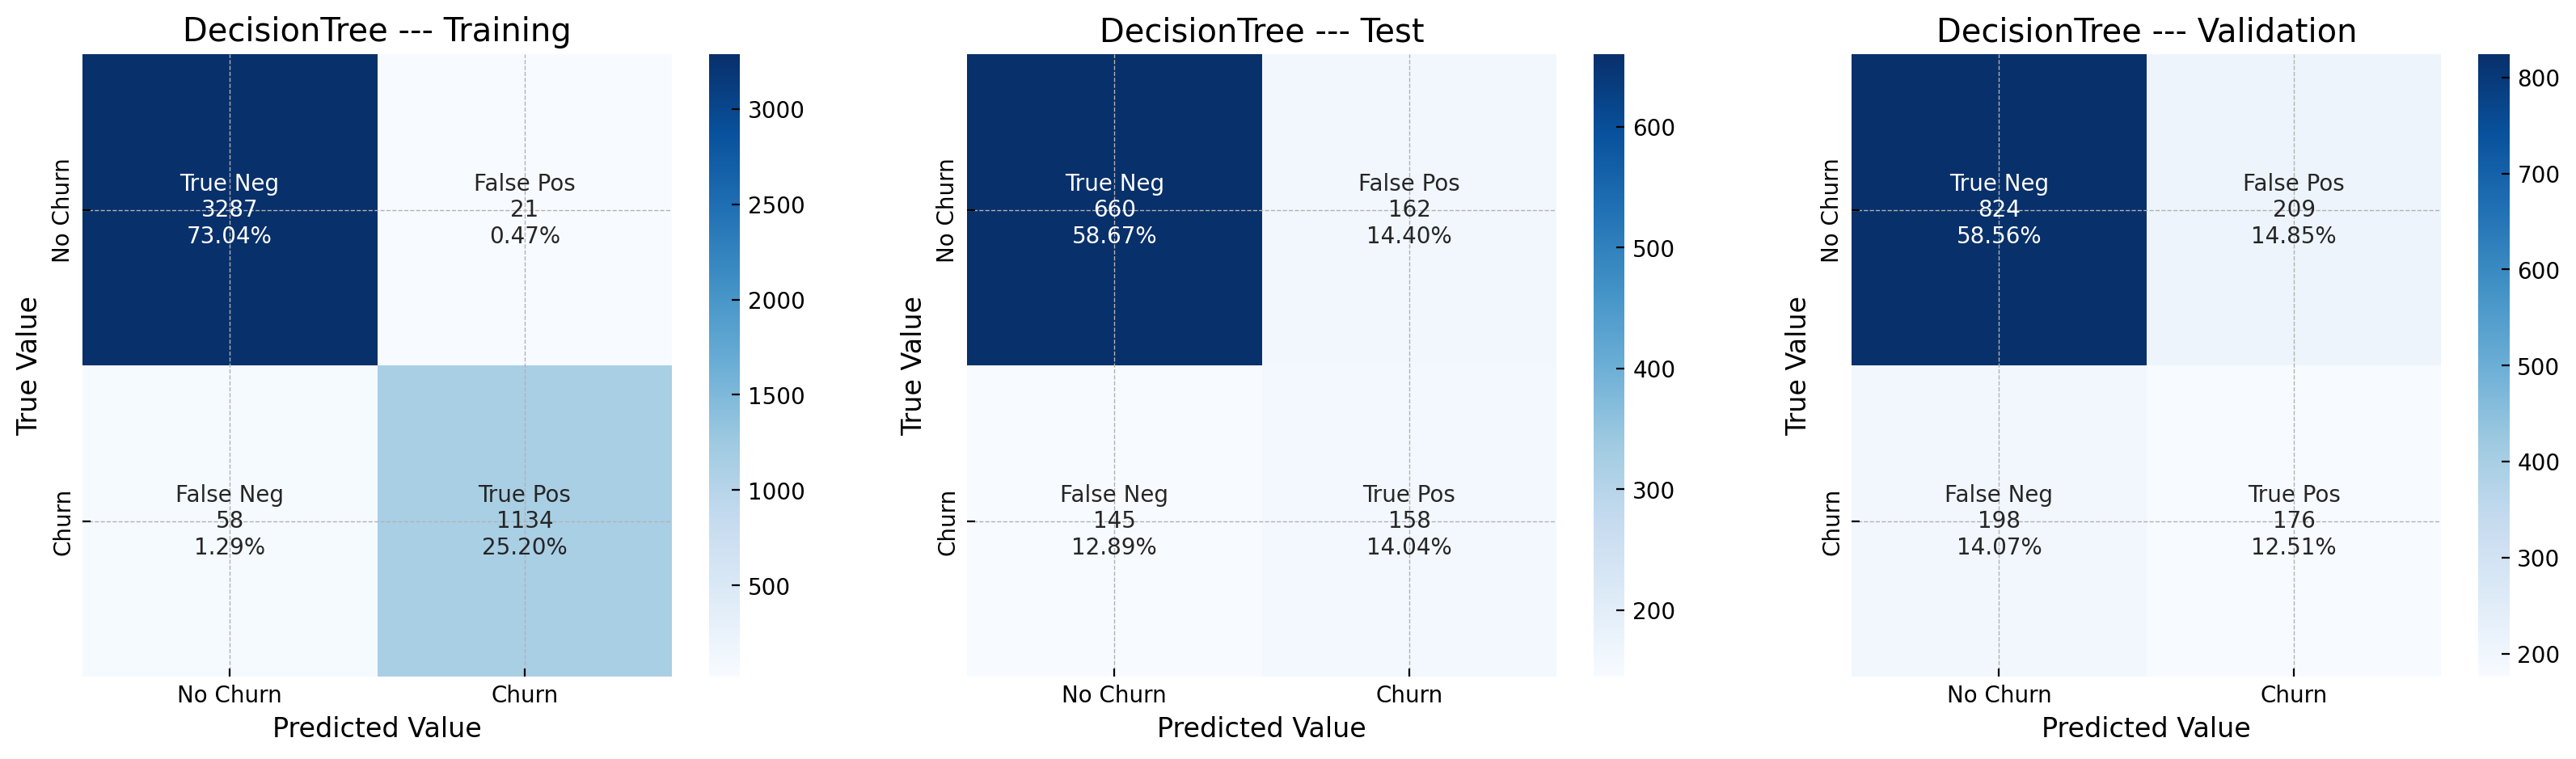

In [23]:
confusion_matrix_viz(tree, X_train, X_test, X_val, y_train, y_test, y_val)

In [40]:
y_pred = tree.predict(X_train)
labels = ['No Churn', 'Churn']

print(classification_report(y_train, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.98      0.99      0.99      3308
       Churn       0.98      0.95      0.97      1192

    accuracy                           0.98      4500
   macro avg       0.98      0.97      0.98      4500
weighted avg       0.98      0.98      0.98      4500



In [41]:
y_pred = tree.predict(X_test)
labels = ['No Churn', 'Churn']

print(classification_report(y_test, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.82      0.80      0.81       822
       Churn       0.49      0.52      0.51       303

    accuracy                           0.73      1125
   macro avg       0.66      0.66      0.66      1125
weighted avg       0.73      0.73      0.73      1125



In [45]:
y_pred = tree.predict(X_val)
labels = ['No Churn', 'Churn']

print(classification_report(y_val, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.81      0.80      0.80      1033
       Churn       0.46      0.47      0.46       374

    accuracy                           0.71      1407
   macro avg       0.63      0.63      0.63      1407
weighted avg       0.71      0.71      0.71      1407



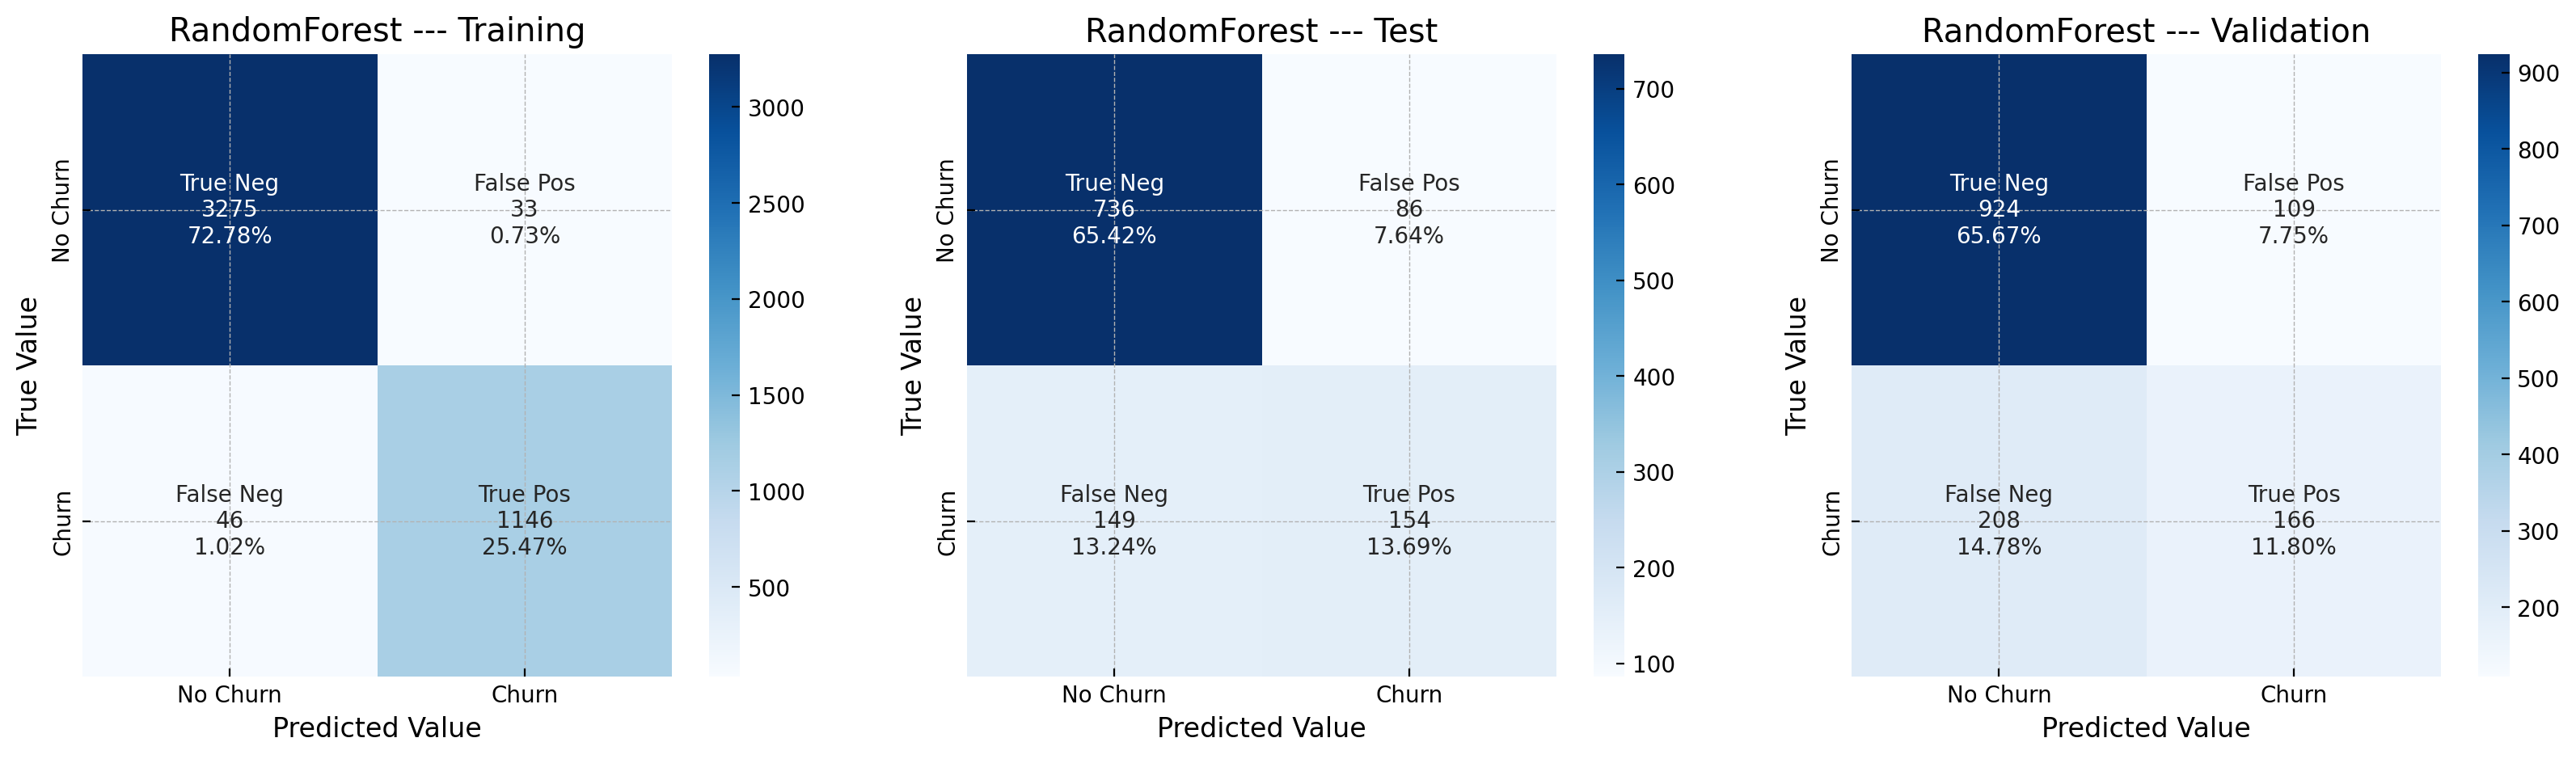

In [46]:
confusion_matrix_viz(forest, X_train, X_test, X_val, y_train, y_test, y_val)

In [47]:
y_pred = forest.predict(X_train)
labels = ['No Churn', 'Churn']

print(classification_report(y_train, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.99      0.99      0.99      3308
       Churn       0.97      0.96      0.97      1192

    accuracy                           0.98      4500
   macro avg       0.98      0.98      0.98      4500
weighted avg       0.98      0.98      0.98      4500



In [48]:
y_pred = forest.predict(X_test)
labels = ['No Churn', 'Churn']

print(classification_report(y_test, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.83      0.90      0.86       822
       Churn       0.64      0.51      0.57       303

    accuracy                           0.79      1125
   macro avg       0.74      0.70      0.71      1125
weighted avg       0.78      0.79      0.78      1125



In [49]:
y_pred = forest.predict(X_val)
labels = ['No Churn', 'Churn']

print(classification_report(y_val, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.82      0.89      0.85      1033
       Churn       0.60      0.44      0.51       374

    accuracy                           0.77      1407
   macro avg       0.71      0.67      0.68      1407
weighted avg       0.76      0.77      0.76      1407



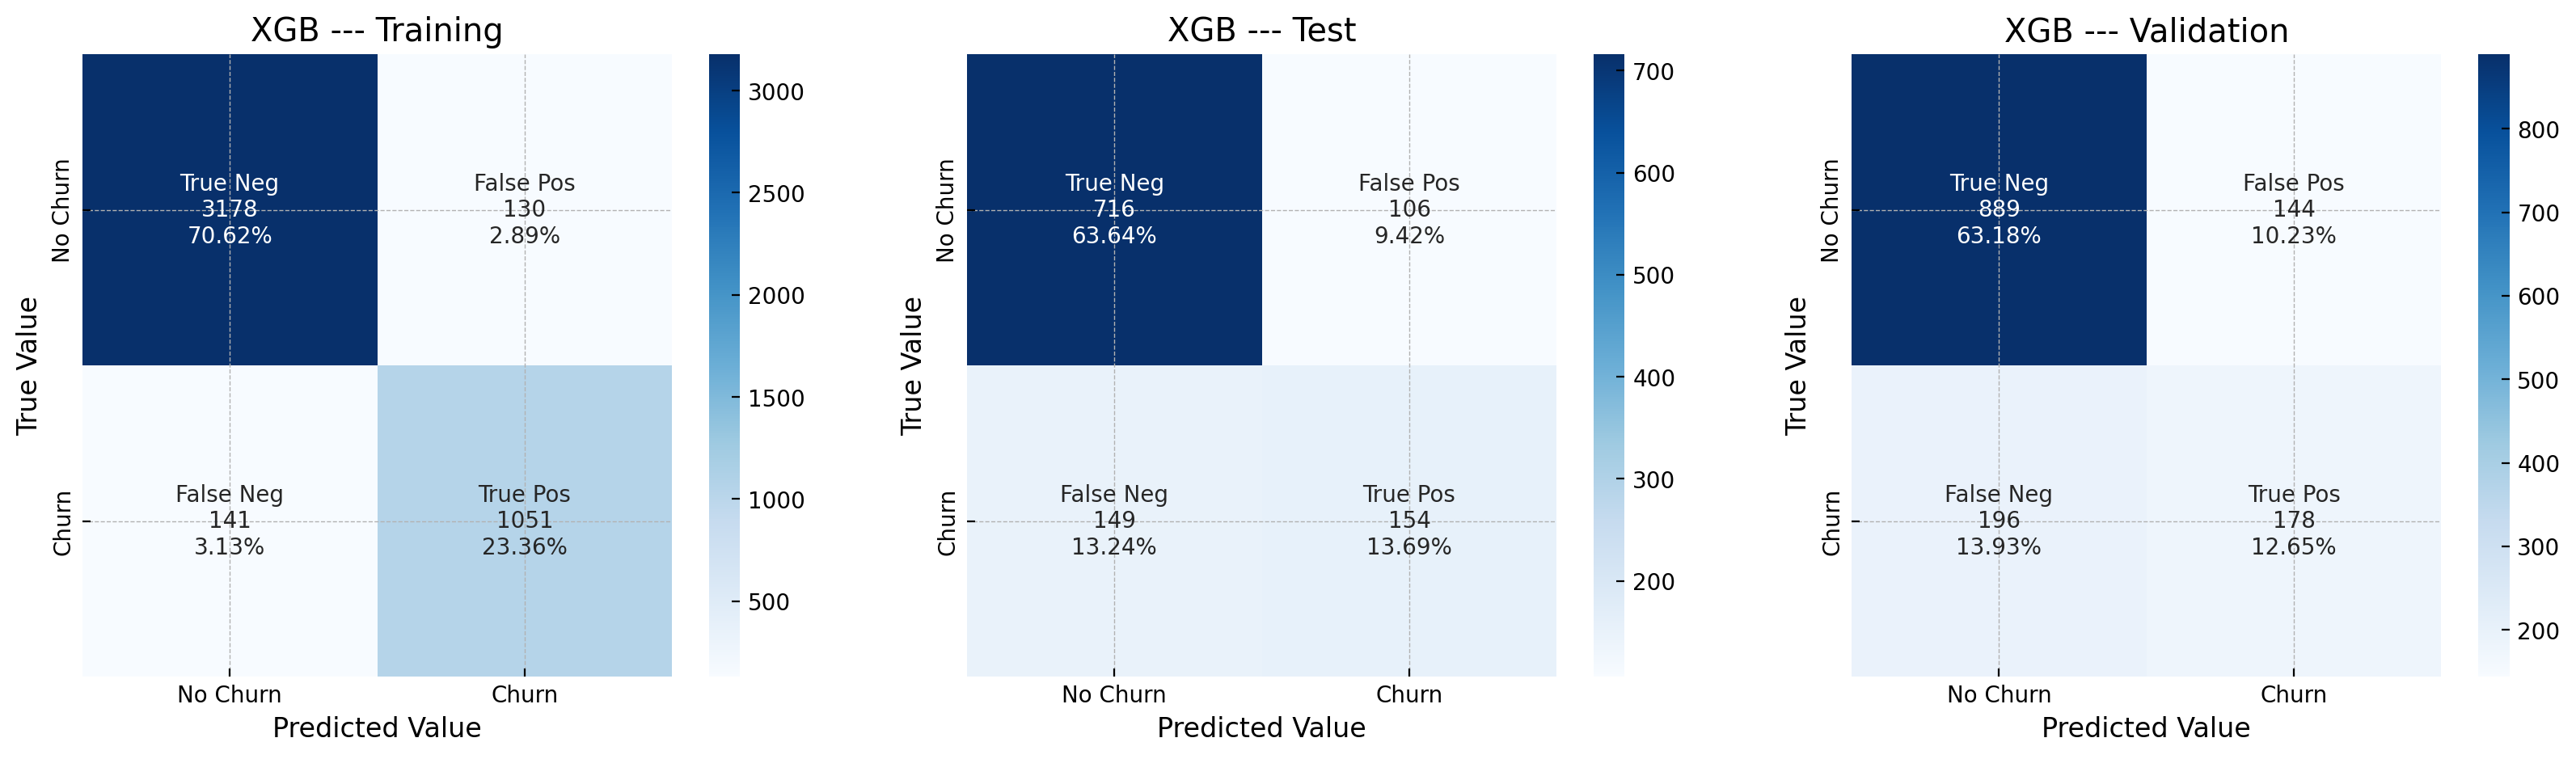

In [52]:
confusion_matrix_viz(xgb, X_train, X_test, X_val, y_train, y_test, y_val)

In [53]:
y_pred = xgb.predict(X_train)
labels = ['No Churn', 'Churn']

print(classification_report(y_train, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.96      0.96      0.96      3308
       Churn       0.89      0.88      0.89      1192

    accuracy                           0.94      4500
   macro avg       0.92      0.92      0.92      4500
weighted avg       0.94      0.94      0.94      4500



In [54]:
y_pred = xgb.predict(X_test)
labels = ['No Churn', 'Churn']

print(classification_report(y_test, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.83      0.87      0.85       822
       Churn       0.59      0.51      0.55       303

    accuracy                           0.77      1125
   macro avg       0.71      0.69      0.70      1125
weighted avg       0.76      0.77      0.77      1125



In [55]:
y_pred = xgb.predict(X_val)
labels = ['No Churn', 'Churn']

print(classification_report(y_val, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.82      0.86      0.84      1033
       Churn       0.55      0.48      0.51       374

    accuracy                           0.76      1407
   macro avg       0.69      0.67      0.68      1407
weighted avg       0.75      0.76      0.75      1407



In [57]:
def feature_importance_viz(model, feature):

    name = type(model).__name__
    name = re.findall('[A-Z][^A-Z]*', name)
    model_name = ''.join(name[:-1])
    
    feature_importance = model.feature_importances_
    importance = pd.Series(feature_importance, index = feature.columns)
    
    fig, ax = plt.subplots(figsize=(7,7))
    importance.plot.barh(ax=ax)
    ax.set_title("Feature importances contribution of " + model_name)
        
    plt.show()

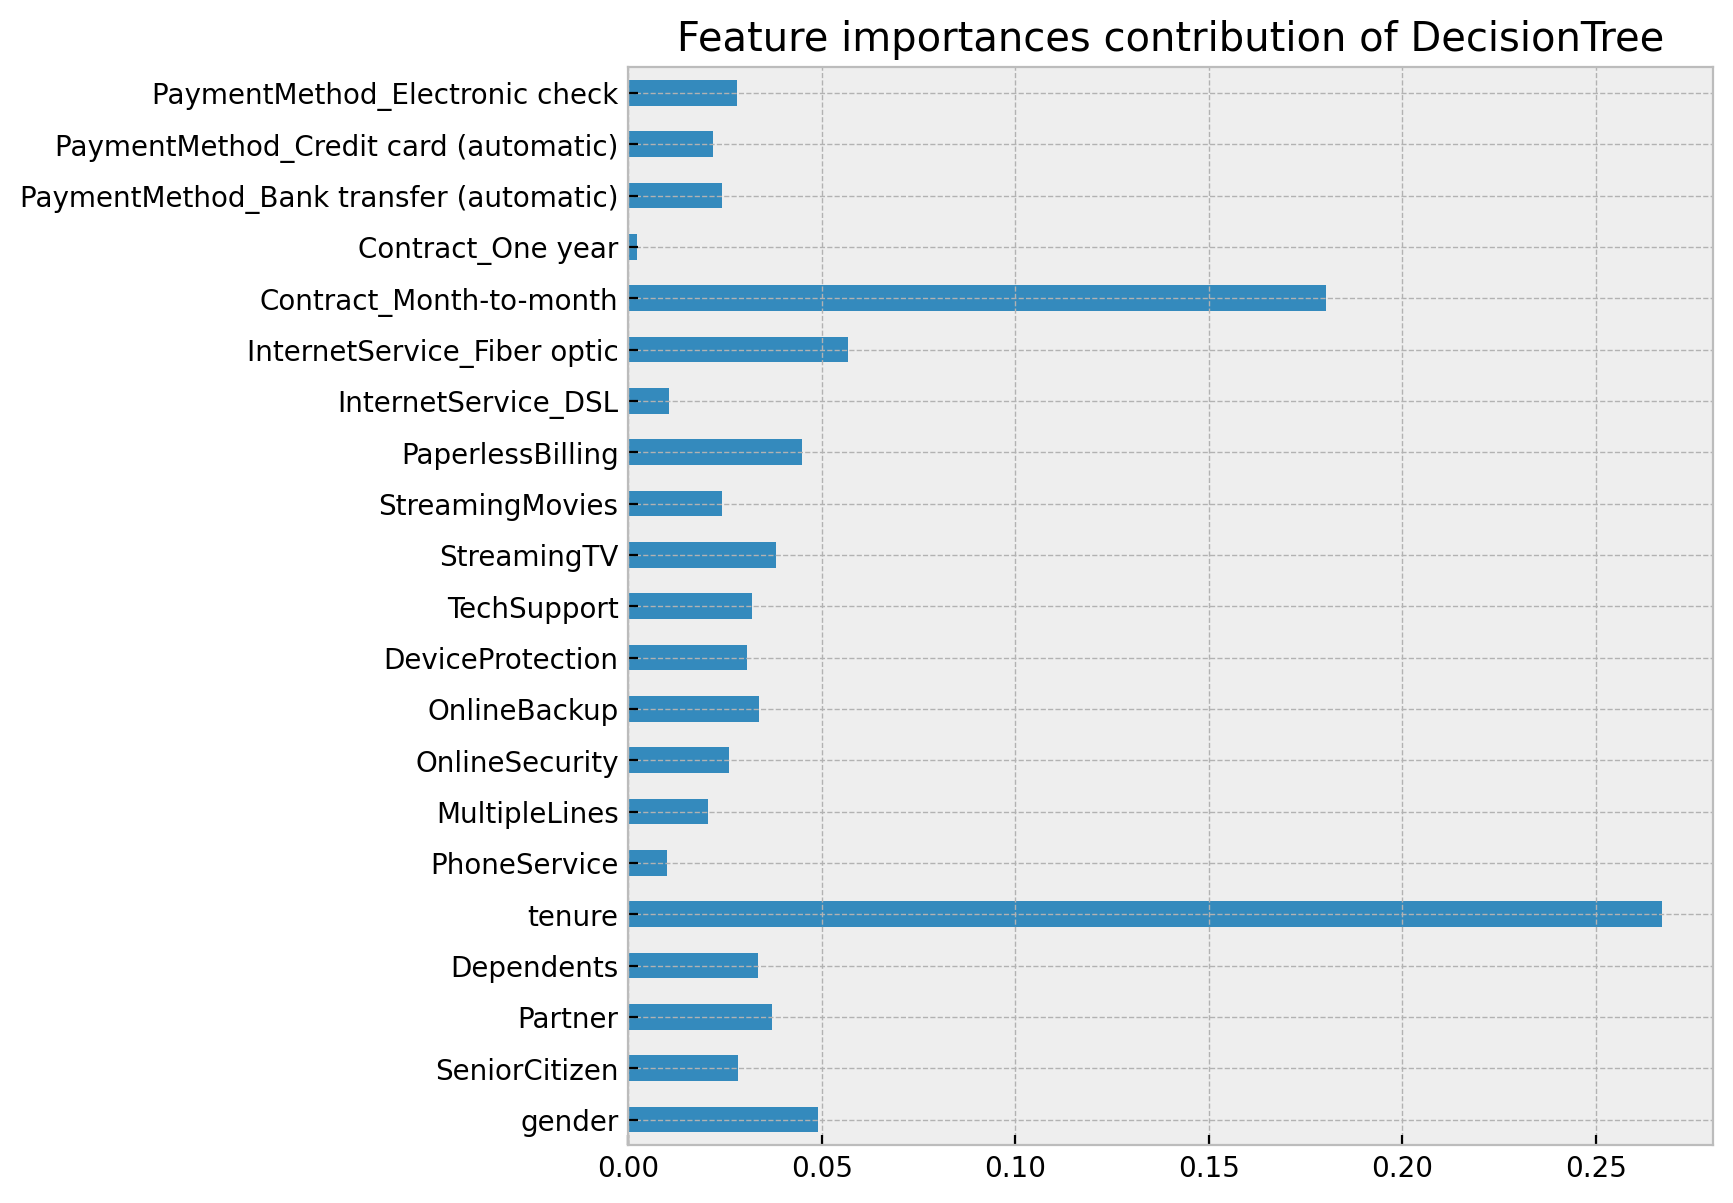

In [58]:
feature_importance_viz(tree, feature)

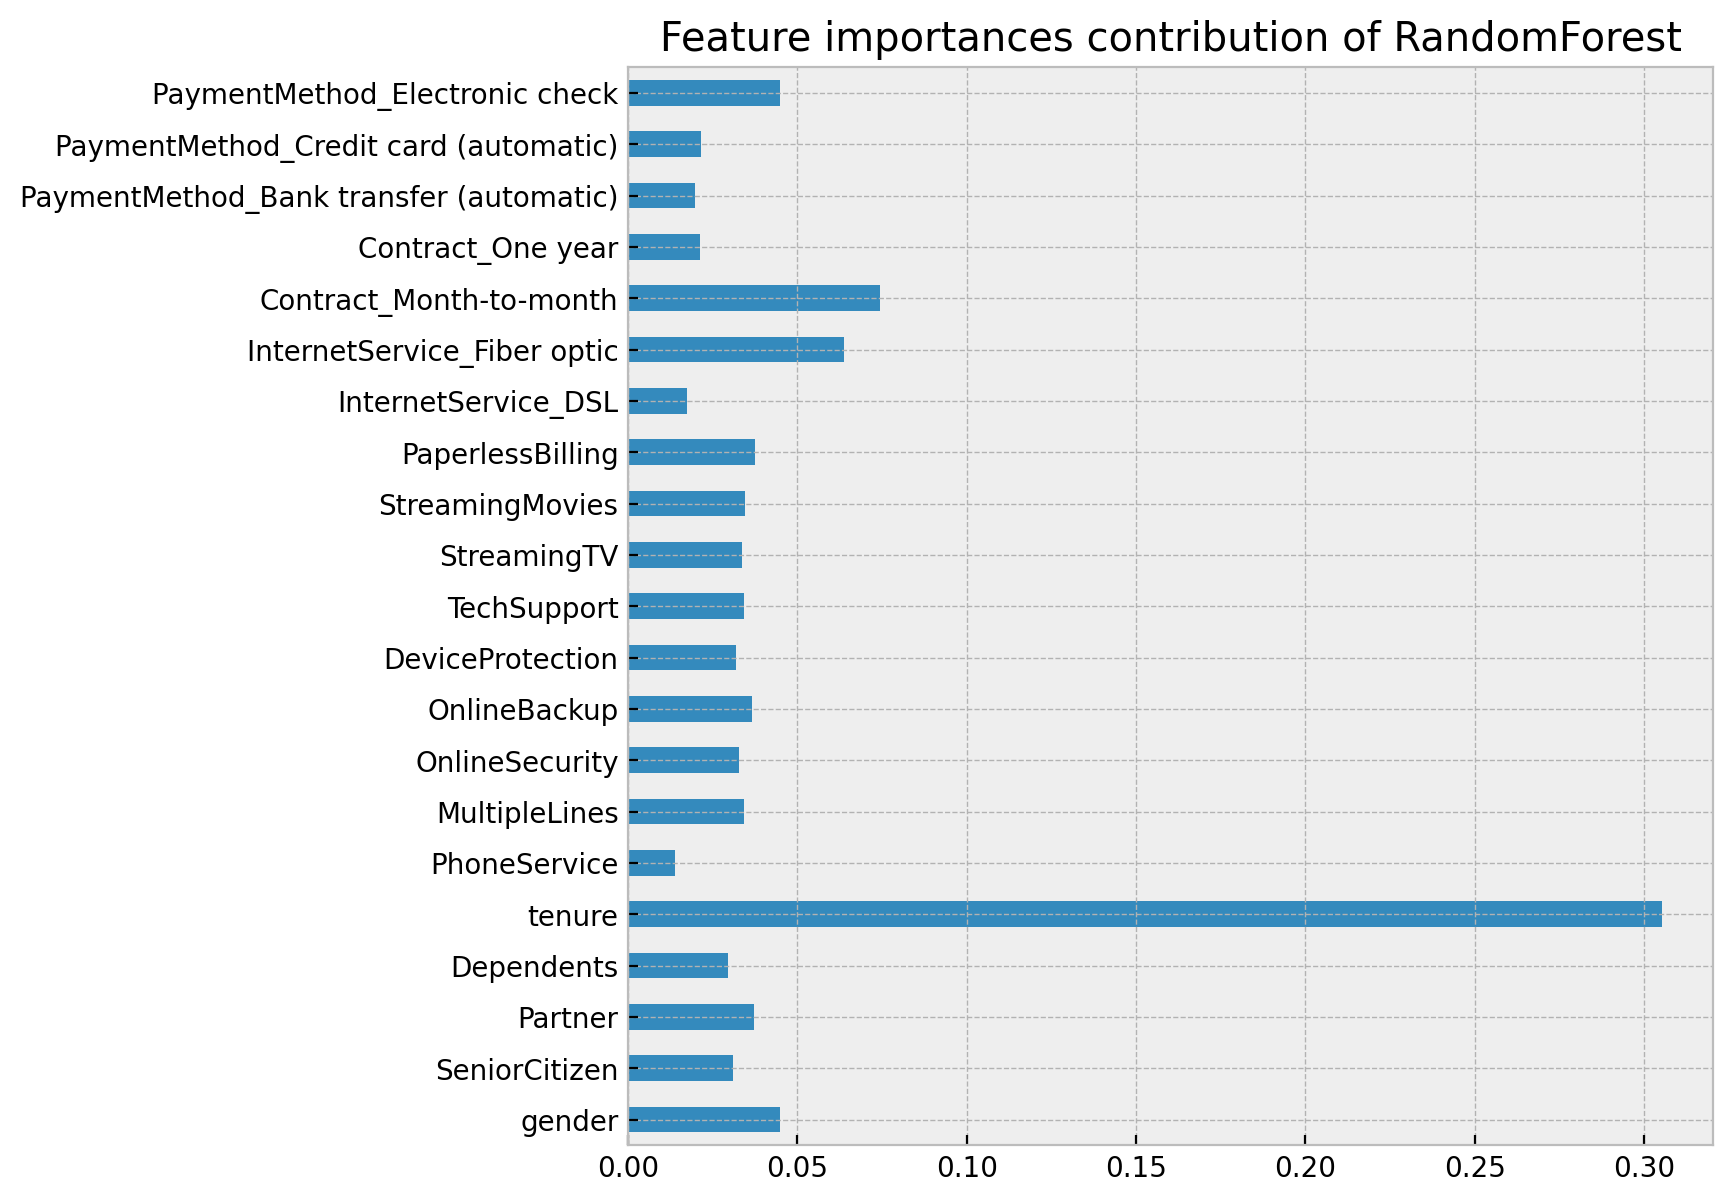

In [59]:
feature_importance_viz(forest, feature)

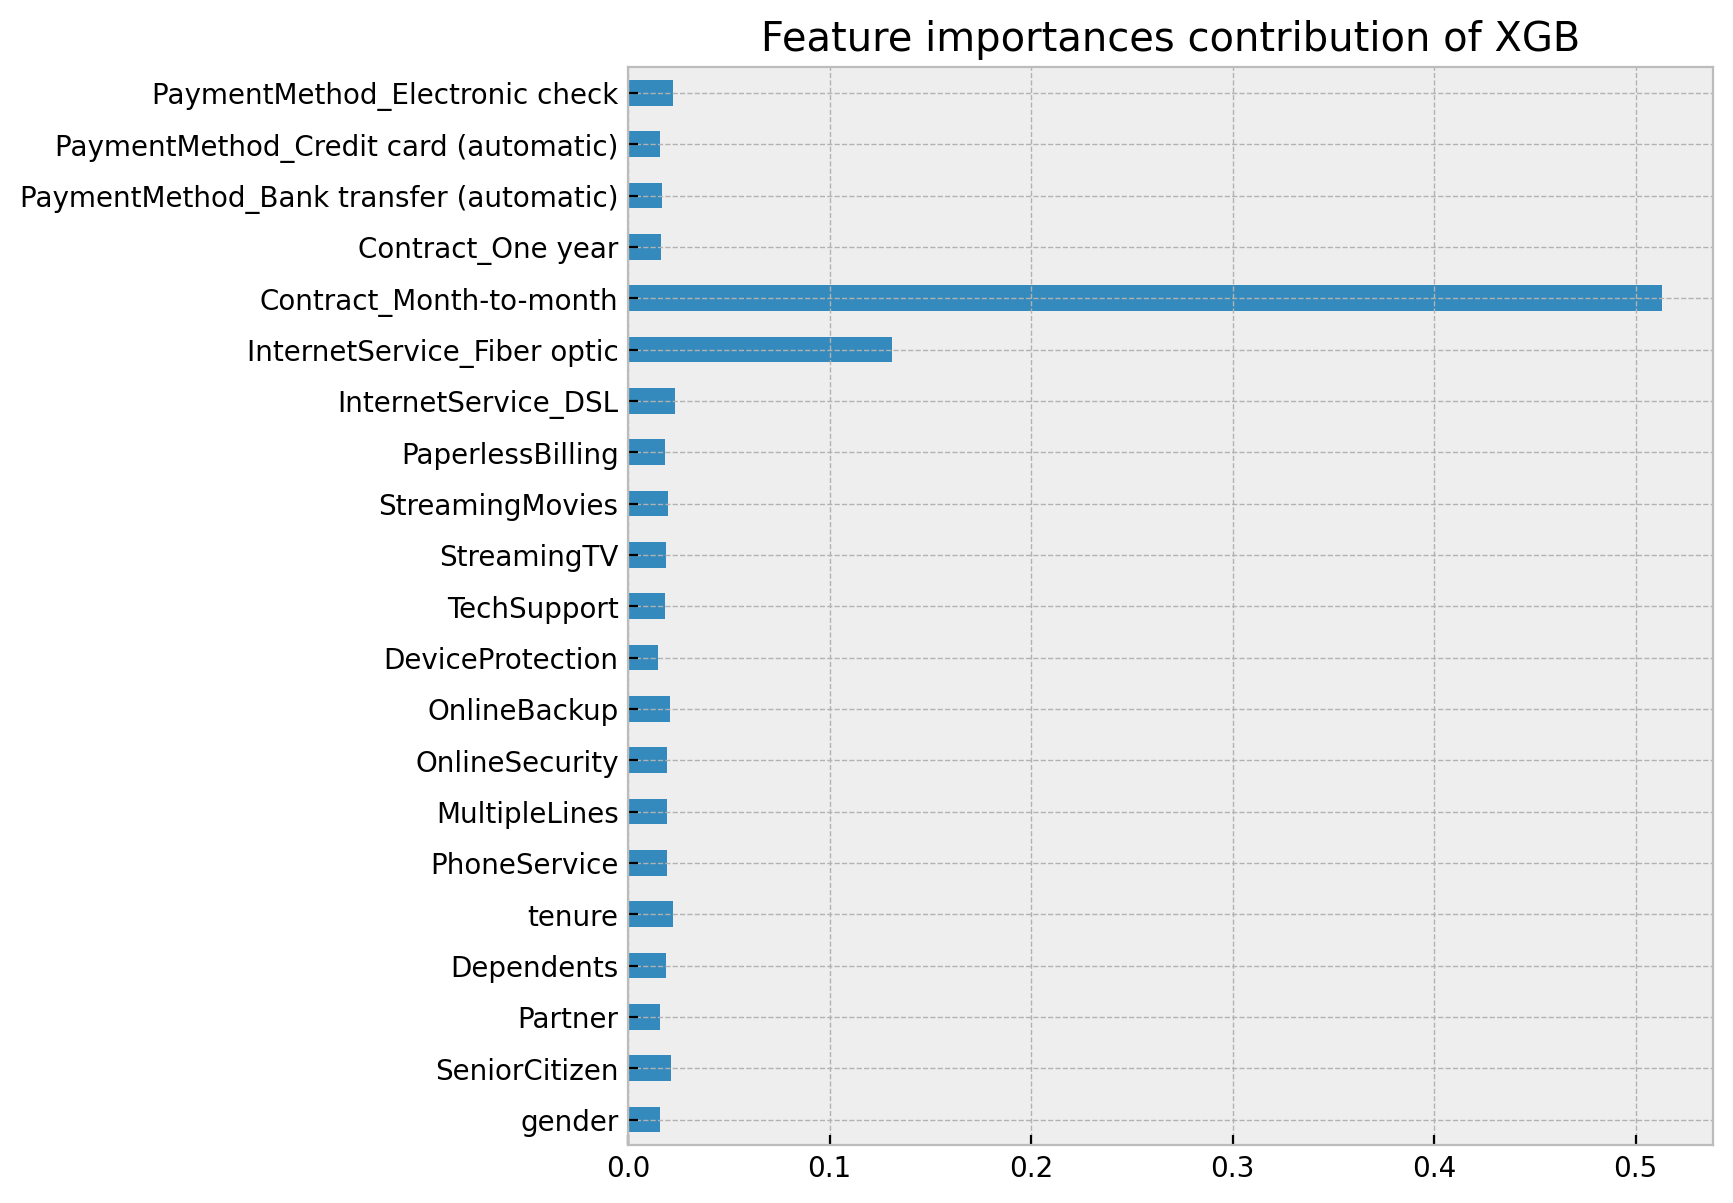

In [60]:
feature_importance_viz(xgb, feature)

### Imbalanced data handling

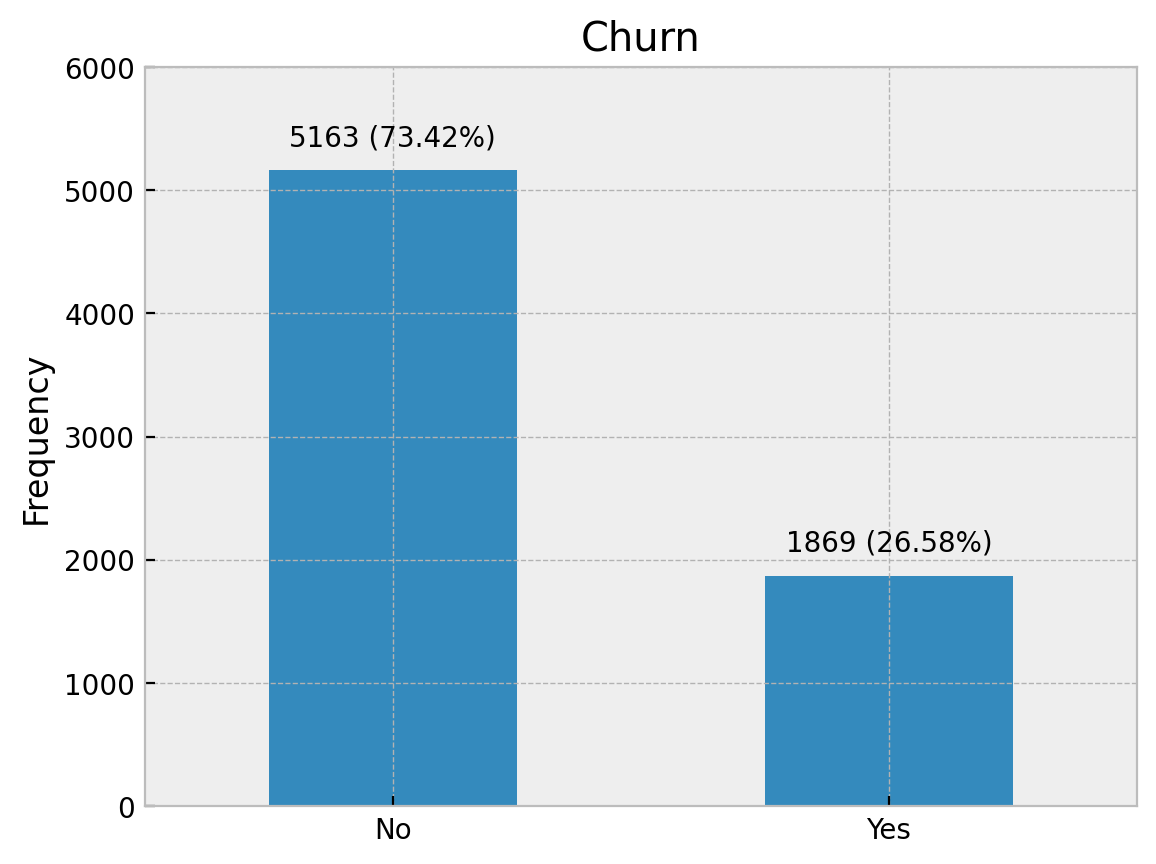

In [61]:
def imbalanced_viz(target):
    target_class = target.map({0 : 'No', 1 : 'Yes'})
    
    target_class.value_counts().plot(kind='bar', title='Churn')
    plt.tick_params(axis='x', rotation=0)
    plt.xlabel('')
    plt.ylabel('Frequency')
    
    counts = target_class.value_counts()
    percentage = counts / np.sum(counts) * 100
    
    labels = [str(counts[0]) + " (" + f'{percentage[0]:.2f}' + '%' + ")",
              str(counts[1]) + " (" + f'{percentage[1]:.2f}' + '%' + ")"]
    
    for i in range(len(labels)):
        plt.text(i, counts[i] + 200, labels[i], 
                 ha='center', color = 'black', fontsize=10)
    
    plt.ylim(0,6000)
    plt.show()

imbalanced_viz(target)

## SMOTE

In [62]:
from imblearn.over_sampling import SMOTE


X_pretrain, X_val, y_pretrain, y_val = train_test_split(feature, target, 
                                                        test_size=0.2,
                                                        random_state = 42)

# do oversampling using smote                                                        
smote = SMOTE(random_state=42, k_neighbors=5)
X_resample, y_resample = smote.fit_resample(X_pretrain, y_pretrain)

# do split again
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, 
                                                    test_size=0.2,
                                                    random_state = 42)


# Training data shape after SMOTE
print('Shape of X_train after SMOTE : {}'.format(X_train.shape))
print('Shape of y_train after SMOTE : {}'.format(y_train.shape))
print()

# Testing data shape after SMOTE
print('Shape of X_test after SMOTE : {}'.format(X_test.shape))
print('Shape of y_test after SMOTE : {}'.format(y_test.shape))
print()

# Valication data shape before SMOTE, this is set as a unlooked up data from machine learning model
print('Shape of X_val before SMOTE : {}'.format(X_val.shape))
print('Shape of y_val before SMOTE : {}'.format(y_val.shape))

Shape of X_train after SMOTE : (6608, 21)
Shape of y_train after SMOTE : (6608,)

Shape of X_test after SMOTE : (1652, 21)
Shape of y_test after SMOTE : (1652,)

Shape of X_val before SMOTE : (1407, 21)
Shape of y_val before SMOTE : (1407,)


In [63]:
# Decision tree classifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# Random forest classifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

# XGBosst classifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

models = [tree, forest, xgb]

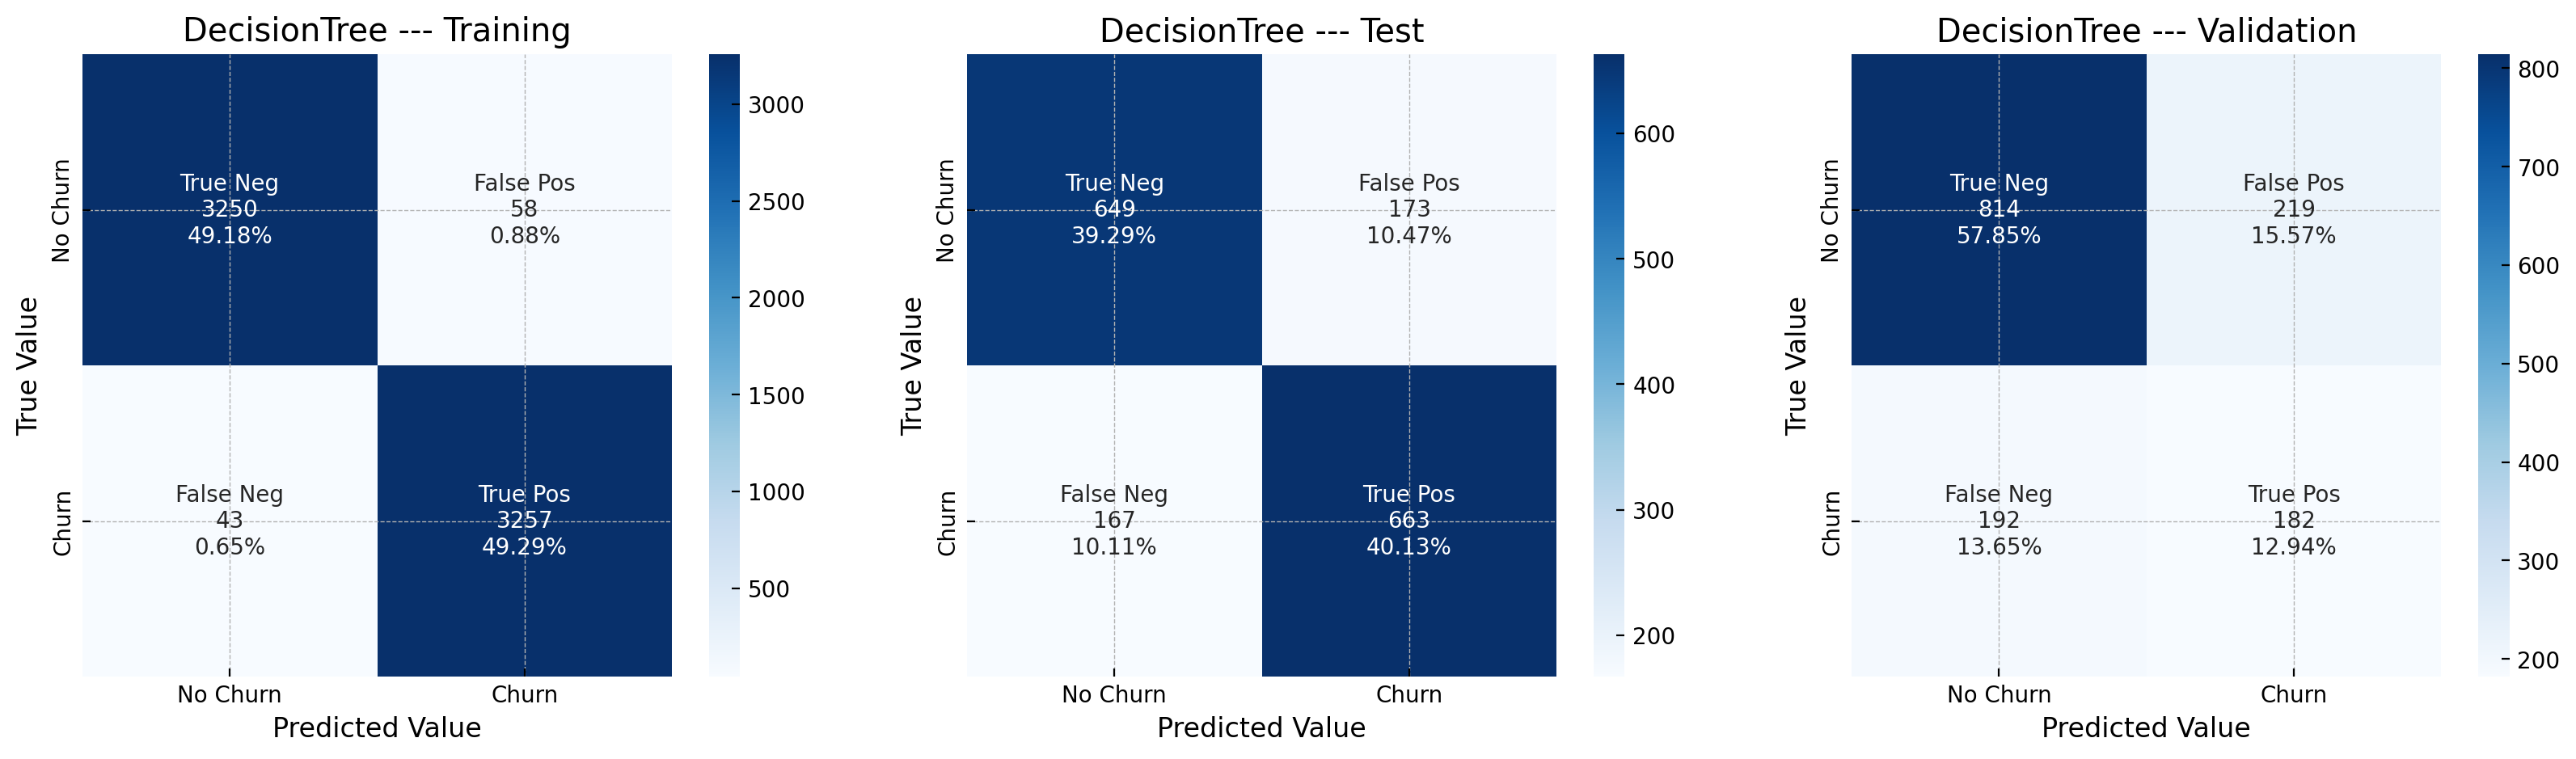

In [65]:
confusion_matrix_viz(tree, X_train, X_test, X_val, y_train, y_test, y_val)

In [66]:
y_pred = tree.predict(X_train)
labels = ['No Churn', 'Churn']

print(classification_report(y_train, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.99      0.98      0.98      3308
       Churn       0.98      0.99      0.98      3300

    accuracy                           0.98      6608
   macro avg       0.98      0.98      0.98      6608
weighted avg       0.98      0.98      0.98      6608



In [67]:
y_pred = tree.predict(X_test)
labels = ['No Churn', 'Churn']

print(classification_report(y_test, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.80      0.79      0.79       822
       Churn       0.79      0.80      0.80       830

    accuracy                           0.79      1652
   macro avg       0.79      0.79      0.79      1652
weighted avg       0.79      0.79      0.79      1652



In [68]:
y_pred = tree.predict(X_val)
labels = ['No Churn', 'Churn']

print(classification_report(y_val, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.81      0.79      0.80      1033
       Churn       0.45      0.49      0.47       374

    accuracy                           0.71      1407
   macro avg       0.63      0.64      0.63      1407
weighted avg       0.71      0.71      0.71      1407



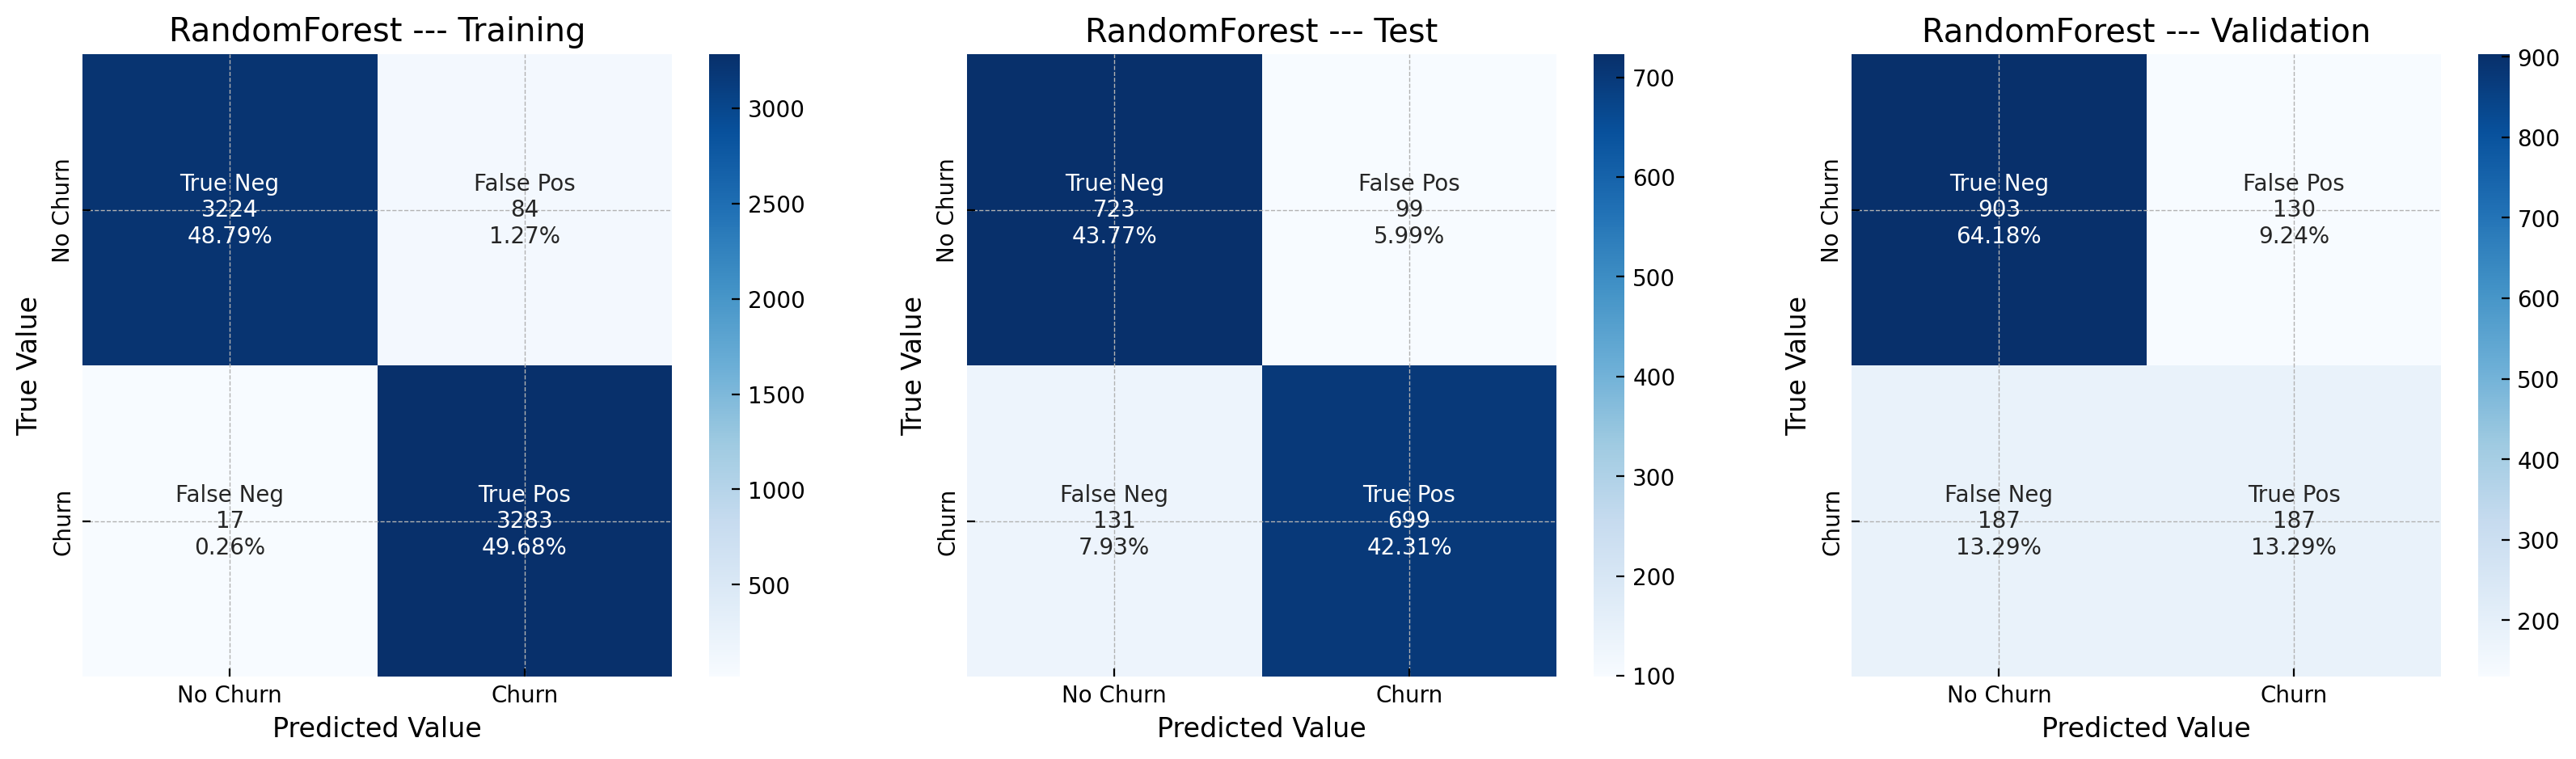

In [69]:
confusion_matrix_viz(forest, X_train, X_test, X_val, y_train, y_test, y_val)

In [70]:
y_pred = forest.predict(X_train)
labels = ['No Churn', 'Churn']

print(classification_report(y_train, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.99      0.97      0.98      3308
       Churn       0.98      0.99      0.98      3300

    accuracy                           0.98      6608
   macro avg       0.98      0.98      0.98      6608
weighted avg       0.98      0.98      0.98      6608



In [71]:
y_pred = forest.predict(X_test)
labels = ['No Churn', 'Churn']

print(classification_report(y_test, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.85      0.88      0.86       822
       Churn       0.88      0.84      0.86       830

    accuracy                           0.86      1652
   macro avg       0.86      0.86      0.86      1652
weighted avg       0.86      0.86      0.86      1652



In [72]:
y_pred = forest.predict(X_val)
labels = ['No Churn', 'Churn']

print(classification_report(y_val, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.83      0.87      0.85      1033
       Churn       0.59      0.50      0.54       374

    accuracy                           0.77      1407
   macro avg       0.71      0.69      0.70      1407
weighted avg       0.77      0.77      0.77      1407



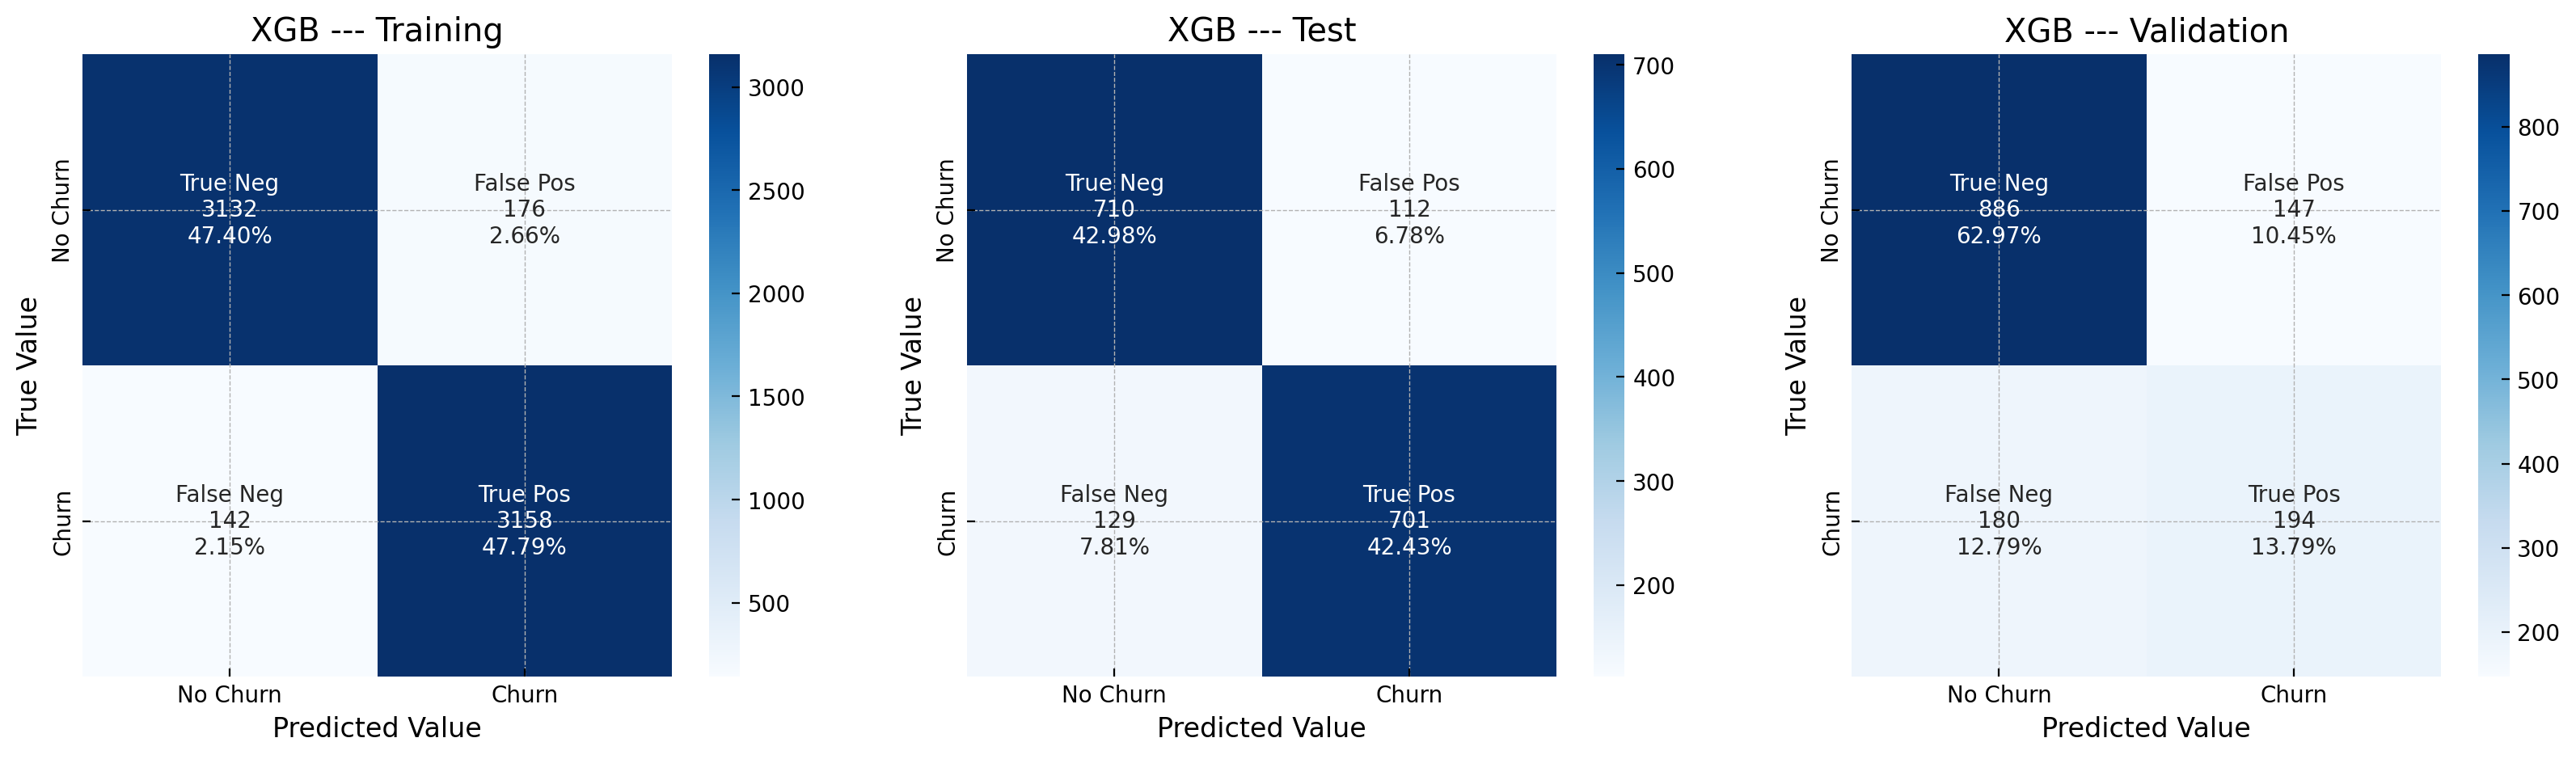

In [73]:
confusion_matrix_viz(xgb, X_train, X_test, X_val, y_train, y_test, y_val)

In [74]:
y_pred = xgb.predict(X_train)
labels = ['No Churn', 'Churn']

print(classification_report(y_train, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.96      0.95      0.95      3308
       Churn       0.95      0.96      0.95      3300

    accuracy                           0.95      6608
   macro avg       0.95      0.95      0.95      6608
weighted avg       0.95      0.95      0.95      6608



In [75]:
y_pred = xgb.predict(X_test)
labels = ['No Churn', 'Churn']

print(classification_report(y_test, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.85      0.86      0.85       822
       Churn       0.86      0.84      0.85       830

    accuracy                           0.85      1652
   macro avg       0.85      0.85      0.85      1652
weighted avg       0.85      0.85      0.85      1652



In [76]:
y_pred = xgb.predict(X_val)
labels = ['No Churn', 'Churn']

print(classification_report(y_val, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.83      0.86      0.84      1033
       Churn       0.57      0.52      0.54       374

    accuracy                           0.77      1407
   macro avg       0.70      0.69      0.69      1407
weighted avg       0.76      0.77      0.76      1407



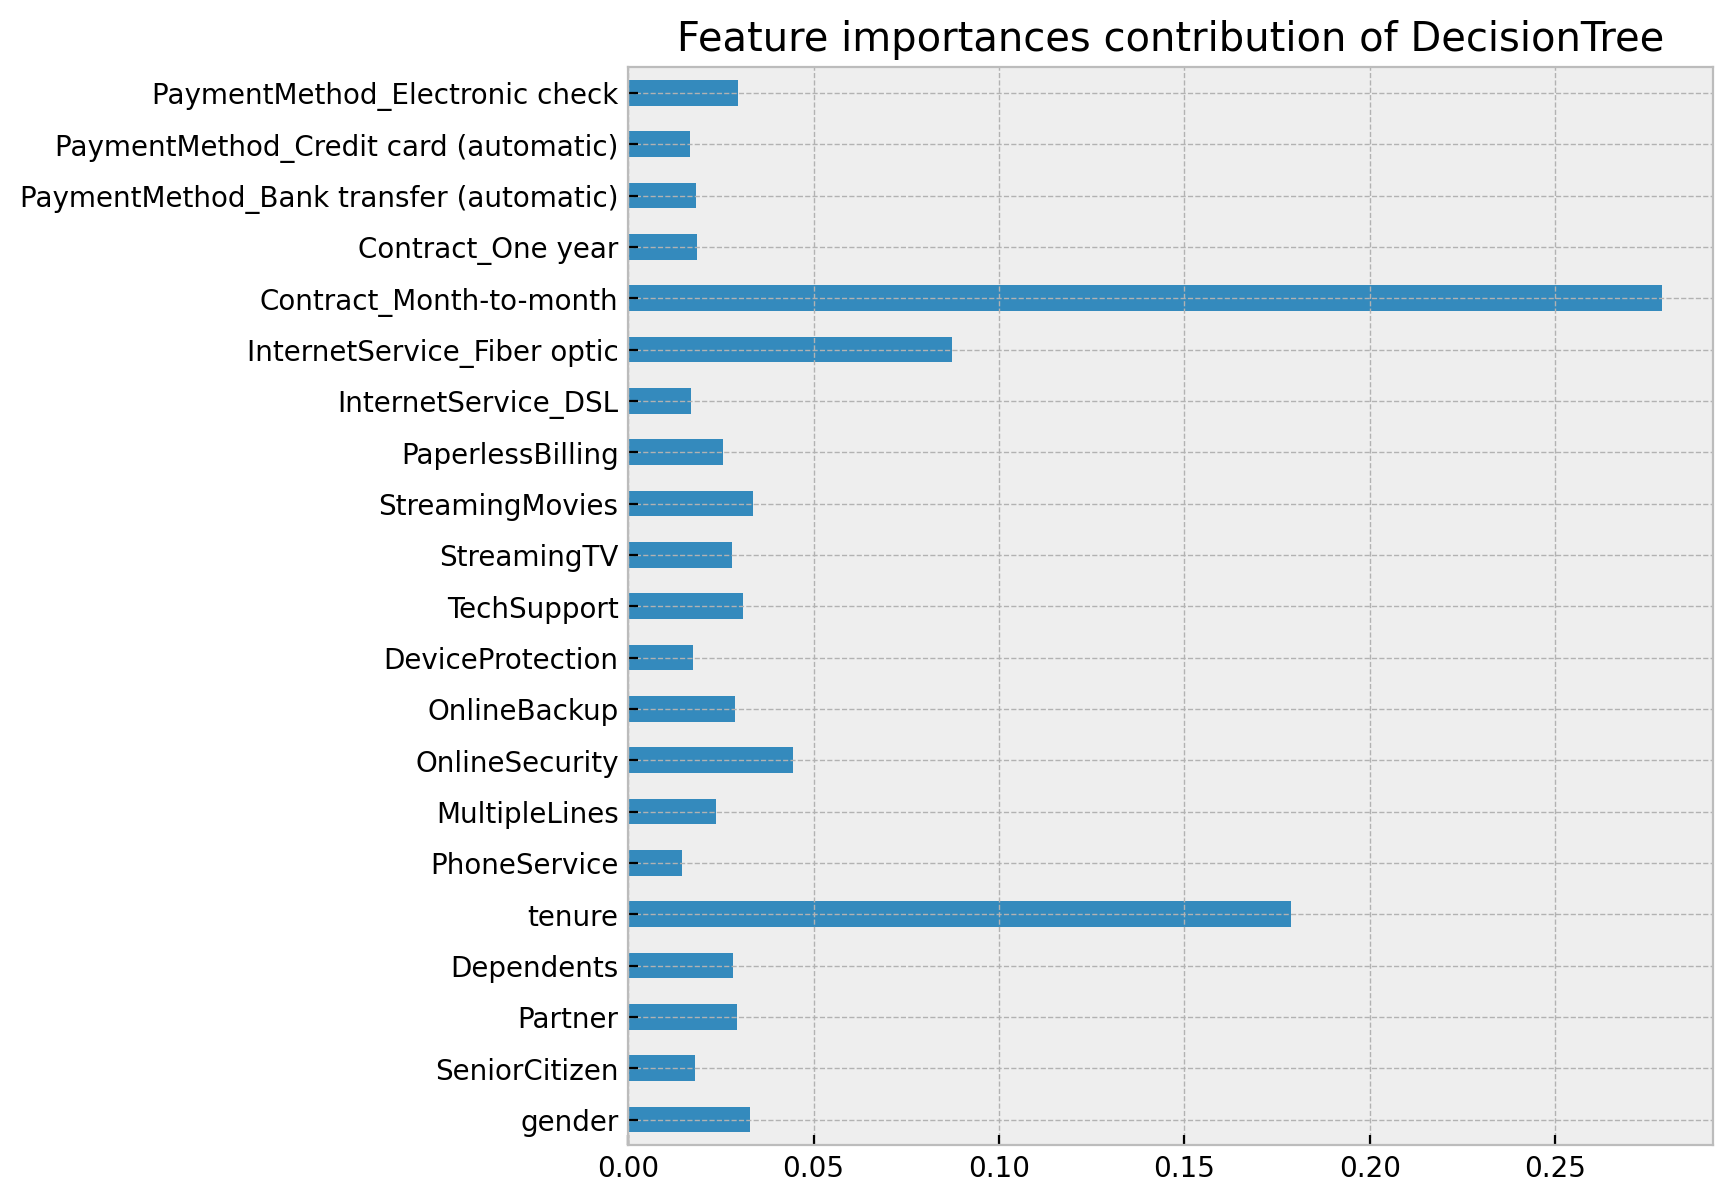

In [77]:
feature_importance_viz(tree, feature)

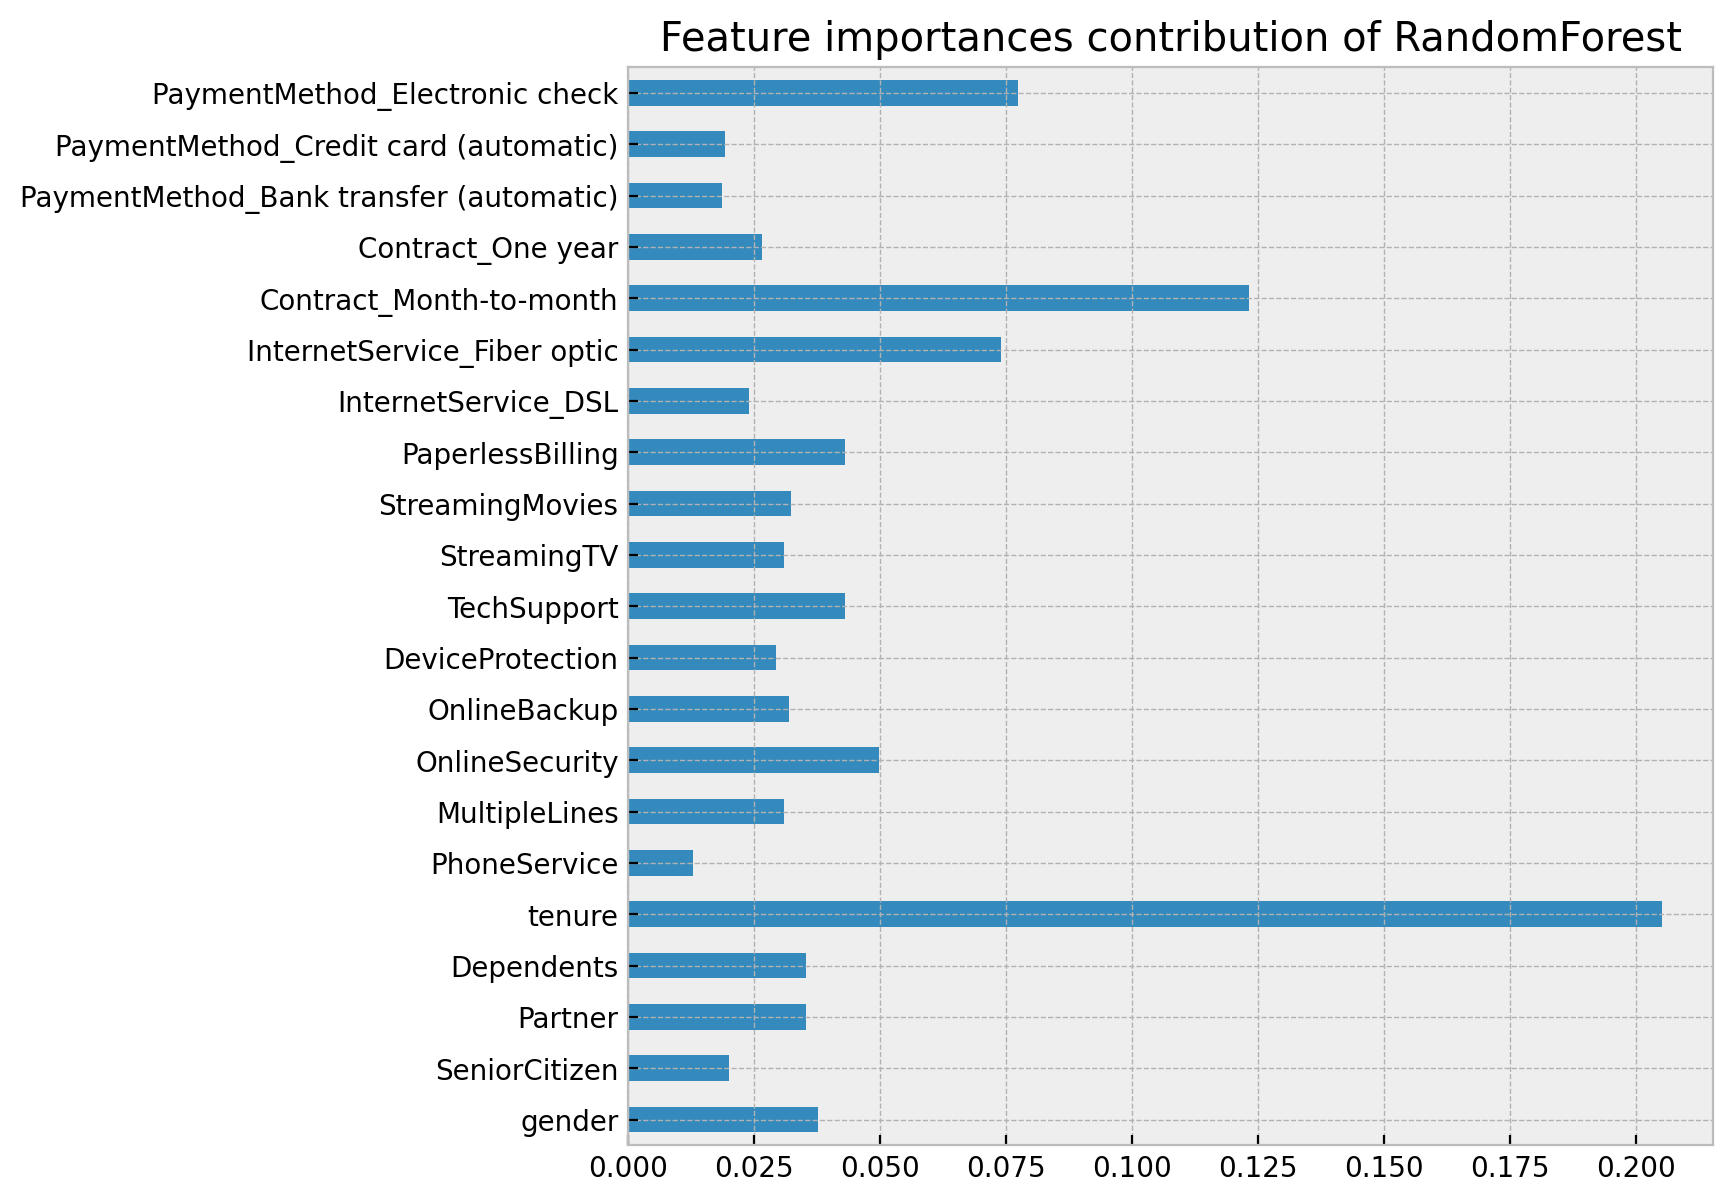

In [78]:
feature_importance_viz(forest, feature)

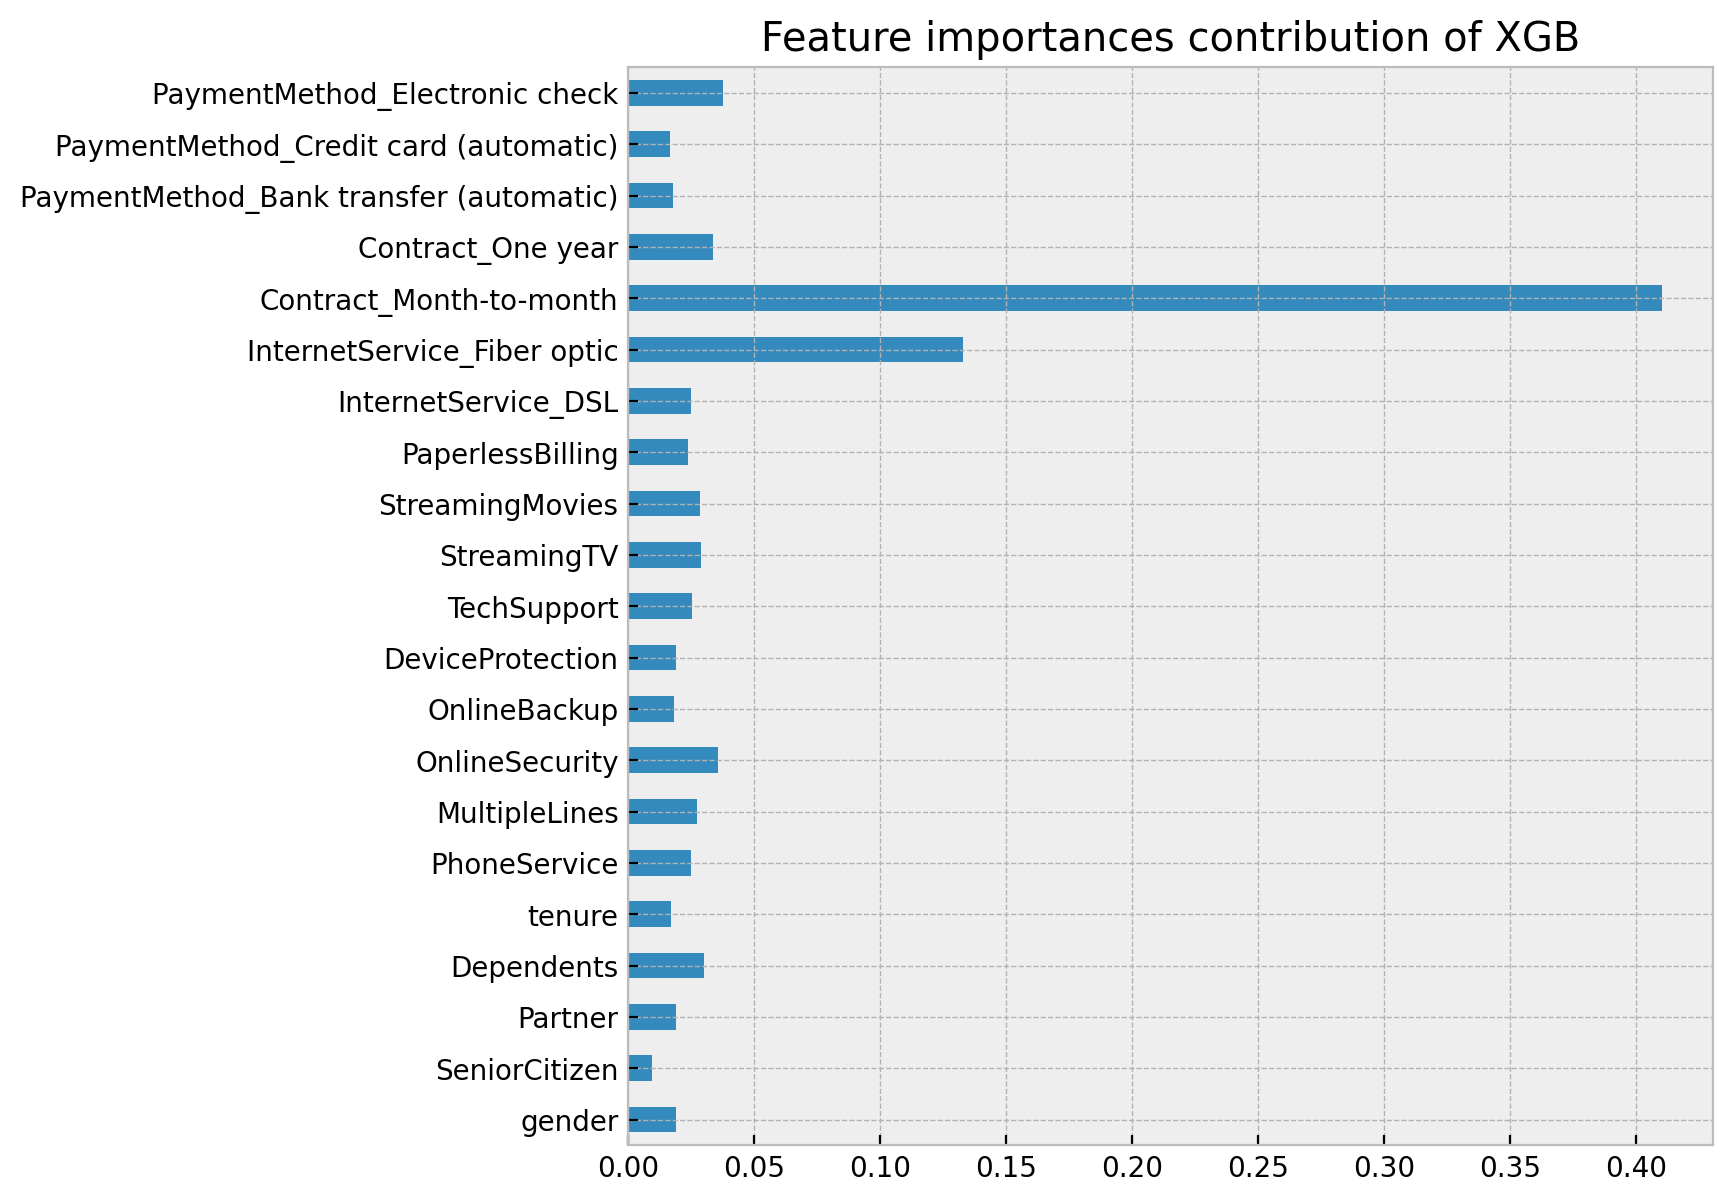

In [79]:
feature_importance_viz(xgb, feature)

## Decision Tree Visualization

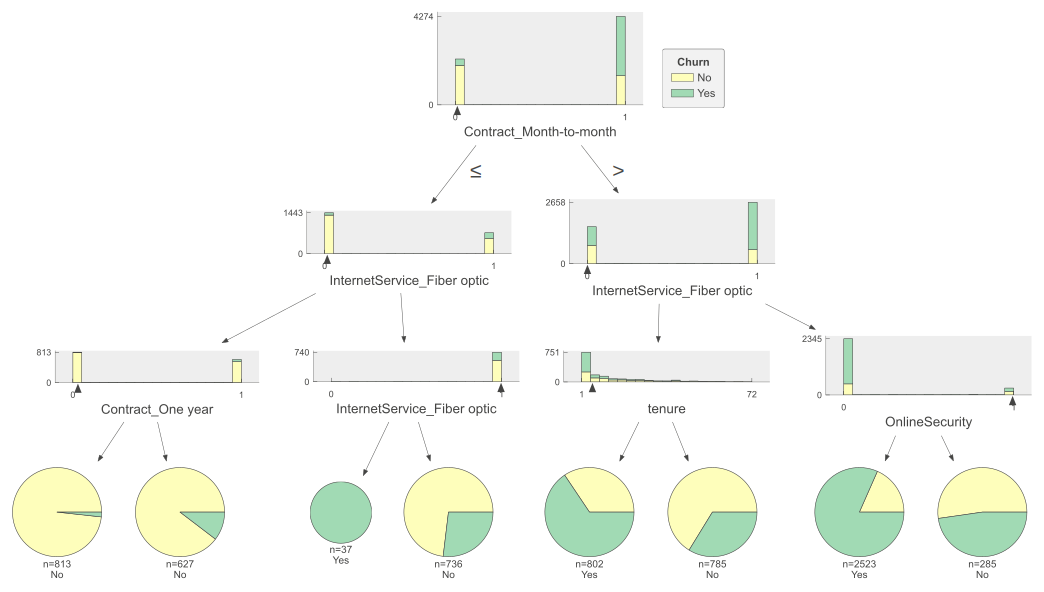

In [80]:
import dtreeviz

tree_viz = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_viz.fit(X_train, y_train)

viz_model = dtreeviz.model(tree_viz, X_train = X_train, y_train = y_train,
                           feature_names = X_train.columns, target_name = y_train.name,
                           class_names = ['No', 'Yes'])

viz_model.view(scale=1.5)

In [81]:
x = X_train.iloc[5]
x

gender                                      1.0
SeniorCitizen                               0.0
Partner                                     1.0
Dependents                                  0.0
tenure                                     63.0
PhoneService                                1.0
MultipleLines                               0.0
OnlineSecurity                              0.0
OnlineBackup                                0.0
DeviceProtection                            0.0
TechSupport                                 0.0
StreamingTV                                 0.0
StreamingMovies                             0.0
PaperlessBilling                            1.0
InternetService_DSL                         0.0
InternetService_Fiber optic                 0.0
Contract_Month-to-month                     0.0
Contract_One year                           0.0
PaymentMethod_Bank transfer (automatic)     1.0
PaymentMethod_Credit card (automatic)       0.0
PaymentMethod_Electronic check          

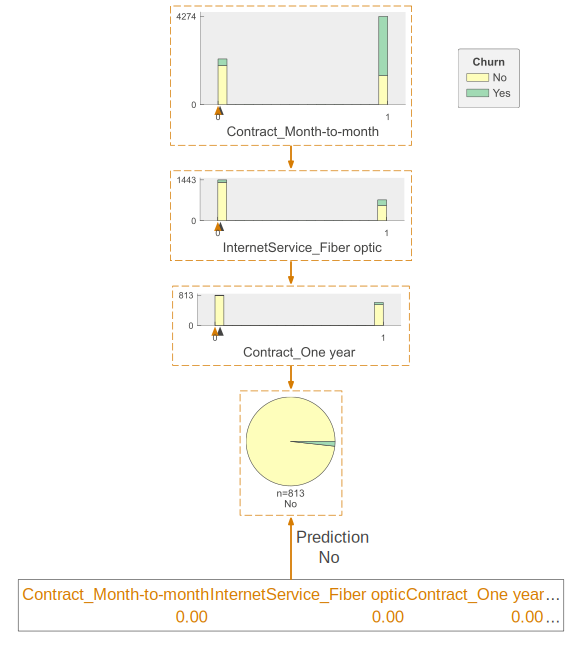

In [82]:
viz_model.view(x=x, scale=1.5, show_just_path=True)

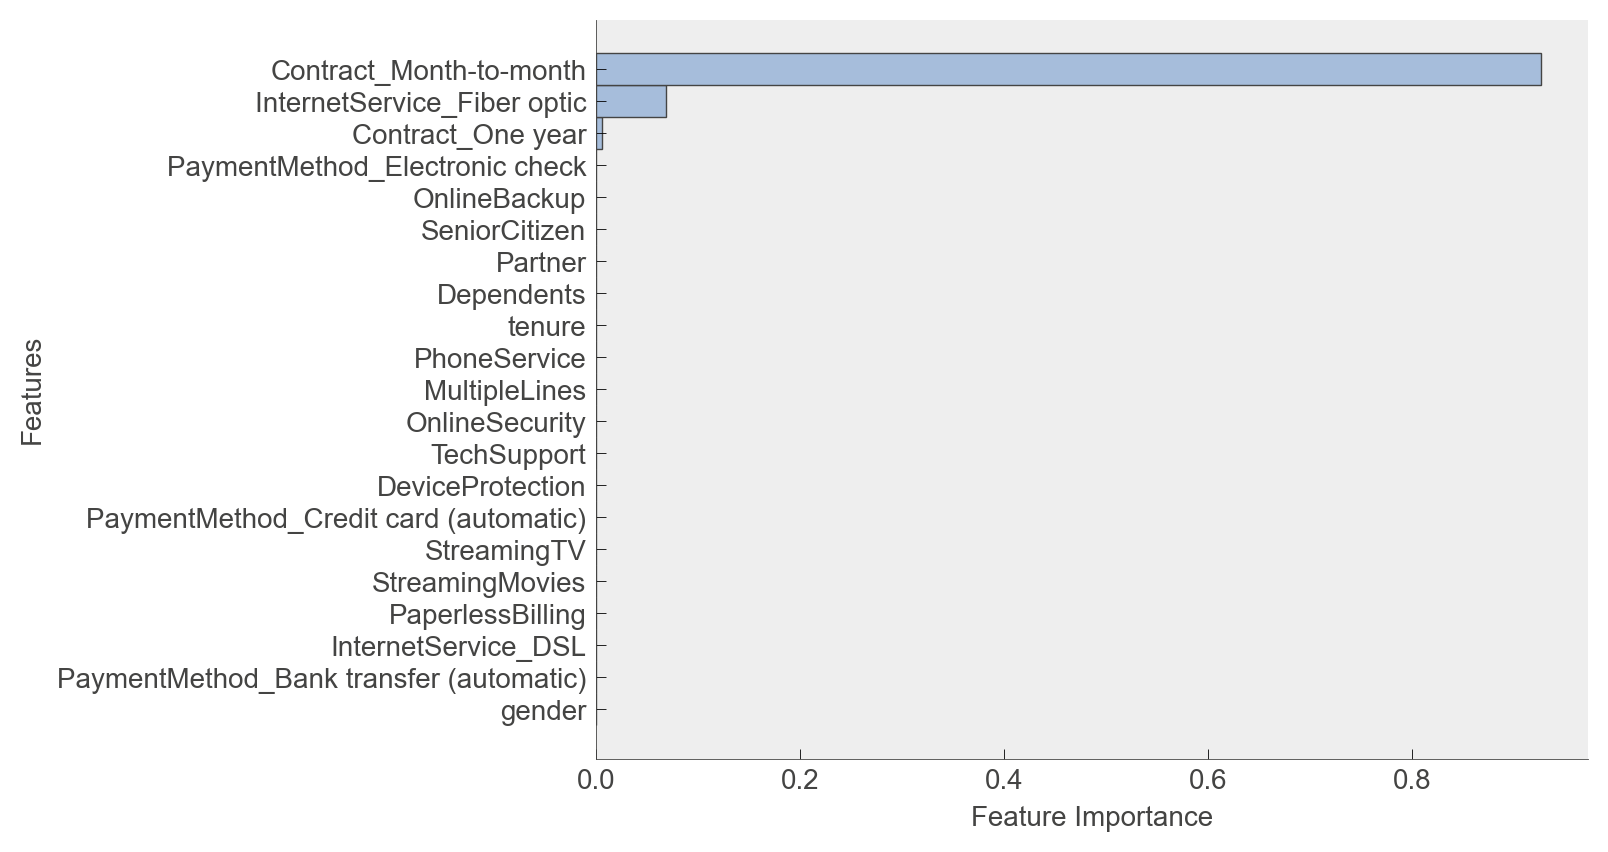

In [83]:
viz_model.instance_feature_importance(x)

## Hyperparameters Tuning

In [84]:
from sklearn.model_selection import GridSearchCV

parameters_tree = {'criterion' : ['gini', 'entropy'],
                   'max_depth' : [2, 3, 5, 7, 9, 11],
                   'min_samples_split' : [2, 4, 6],
                   'max_leaf_nodes' : [3, 5, 7, 9, 11, 13, 15, 17, 19]}

gridcv_tree = GridSearchCV(DecisionTreeClassifier(), parameters_tree, cv=5, n_jobs=-1)

# conduct grid search over the parameter space
start_time = time.time()
gridcv_tree.fit(X_train,y_train)
duration = time.time() - start_time

In [85]:
# show best parameter configuration found for classifier
print('Best parameters for Decision Tree : {}'.format(gridcv_tree.best_params_))
print('Computation time : %.2f' %duration)

tree_best = gridcv_tree.best_estimator_

Best parameters for Decision Tree : {'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': 19, 'min_samples_split': 2}
Computation time : 21.67


In [89]:
y_pred_train = tree_best.predict(X_train)

In [90]:
y_pred_test = tree_best.predict(X_test)

In [88]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      3308
           1       0.81      0.81      0.81      3300

    accuracy                           0.81      6608
   macro avg       0.81      0.81      0.81      6608
weighted avg       0.81      0.81      0.81      6608



In [91]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       822
           1       0.82      0.81      0.81       830

    accuracy                           0.81      1652
   macro avg       0.81      0.81      0.81      1652
weighted avg       0.81      0.81      0.81      1652



In [92]:
y_pred_val = tree_best.predict(X_val)

print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1033
           1       0.52      0.66      0.58       374

    accuracy                           0.75      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.77      0.75      0.76      1407

